# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

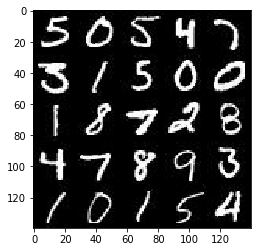

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

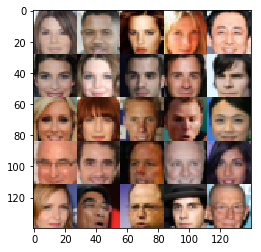

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None , image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    drop = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        #print ('Images:',images.shape)
        #Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              padding='same', use_bias=False, activation=None)
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.layers.dropout(x1, rate=drop, training=True)
        relu1 = tf.maximum(alpha * x1, x1)
        #relu1 = tf.nn.dropout(relu1, drop)
        #16x16x32
        #print ('L1:',relu1.shape)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              padding='same',use_bias=False, activation=None)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        bn2 = tf.layers.dropout(bn2, rate=drop, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #relu2 = tf.nn.dropout(relu2, drop)
        
        #8x8x128
        #print ('L2:',relu2.shape)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              padding='same',use_bias=False, activation=None)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        bn3 = tf.layers.dropout(bn3, rate=drop, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #relu3 = tf.nn.dropout(relu3, drop)
        #print ('L3:',relu3.shape)
        
        #Flatten 
        flat = tf.reshape(relu3, (-1, 4*4*256))
        #print ('Out:', flat.shape)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    drop = 0.5
    xavier = tf.contrib.layers.xavier_initializer_conv2d()
    with tf.variable_scope('generator', reuse=(not is_train)):
        #print ('z:',z.shape)
        x1 = tf.layers.dense(z, 4*4*256)
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        bn1 = tf.layers.dropout(bn1, rate=drop, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        #print ('GL1:',relu1.shape)
        #256
        x2 = tf.layers.conv2d_transpose(relu1, 128, 4, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              padding='valid')
        #x2 = tf.layers.dropout(x2, rate=drop, training=True)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print ('GL2:',relu2.shape)
        #128
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        bn3 = tf.layers.dropout(bn3, rate=drop, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print ('GL3:',relu3.shape)
        
        #Output
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same') 
        #print ('Out:',logits.shape)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample, if it is real, then replace the label with a random number between 0.7 and 1.2, and if it is a fake sample, replace it with 0.0 and 0.3 (for example).
    #Salimans et. al. 2016
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*np.random.uniform(0.0, 0.9)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*np.random.uniform(0.0, 0.9)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                #Normalize
                batch_images *= 2
                #Sample Noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #Optimizer 
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, learn_rate: learning_rate})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 6.6167
Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 1.6705
Epoch 1/2... Discriminator Loss: 0.7597... Generator Loss: 3.1203
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 3.8097
Epoch 1/2... Discriminator Loss: 0.8449... Generator Loss: 1.9559
Epoch 1/2... Discriminator Loss: 0.6363... Generator Loss: 4.4234
Epoch 1/2... Discriminator Loss: 0.6025... Generator Loss: 3.3128
Epoch 1/2... Discriminator Loss: 0.5546... Generator Loss: 3.6192
Epoch 1/2... Discriminator Loss: 0.6075... Generator Loss: 4.0272


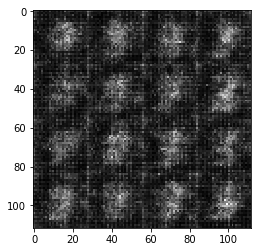

Epoch 1/2... Discriminator Loss: 0.9289... Generator Loss: 5.9021
Epoch 1/2... Discriminator Loss: 0.5850... Generator Loss: 3.2355
Epoch 1/2... Discriminator Loss: 0.5624... Generator Loss: 3.4117
Epoch 1/2... Discriminator Loss: 0.6470... Generator Loss: 4.6036
Epoch 1/2... Discriminator Loss: 0.6388... Generator Loss: 3.1721
Epoch 1/2... Discriminator Loss: 0.5813... Generator Loss: 3.3534
Epoch 1/2... Discriminator Loss: 0.6802... Generator Loss: 4.0785
Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 3.7308
Epoch 1/2... Discriminator Loss: 0.6539... Generator Loss: 3.9370
Epoch 1/2... Discriminator Loss: 0.7583... Generator Loss: 2.1247


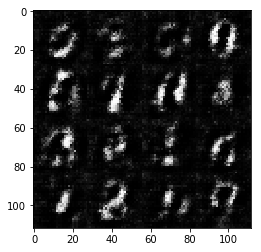

Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 3.7480
Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 4.4122
Epoch 1/2... Discriminator Loss: 0.6369... Generator Loss: 3.2762
Epoch 1/2... Discriminator Loss: 0.6134... Generator Loss: 2.9869
Epoch 1/2... Discriminator Loss: 0.6039... Generator Loss: 3.7751
Epoch 1/2... Discriminator Loss: 0.6511... Generator Loss: 4.0164
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 4.0833
Epoch 1/2... Discriminator Loss: 0.5854... Generator Loss: 3.0759
Epoch 1/2... Discriminator Loss: 0.5580... Generator Loss: 3.2139
Epoch 1/2... Discriminator Loss: 0.6522... Generator Loss: 3.7598


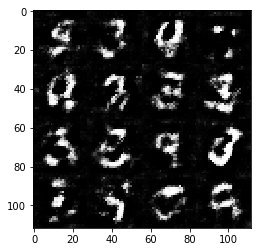

Epoch 1/2... Discriminator Loss: 0.6933... Generator Loss: 3.9145
Epoch 1/2... Discriminator Loss: 0.6626... Generator Loss: 2.4683
Epoch 1/2... Discriminator Loss: 0.5774... Generator Loss: 3.3985
Epoch 1/2... Discriminator Loss: 0.5876... Generator Loss: 3.0516
Epoch 1/2... Discriminator Loss: 0.6314... Generator Loss: 2.2864
Epoch 1/2... Discriminator Loss: 0.5920... Generator Loss: 3.4765
Epoch 1/2... Discriminator Loss: 0.6374... Generator Loss: 2.4863
Epoch 1/2... Discriminator Loss: 0.5655... Generator Loss: 3.5066
Epoch 1/2... Discriminator Loss: 0.5796... Generator Loss: 2.6591
Epoch 1/2... Discriminator Loss: 0.6065... Generator Loss: 3.8335


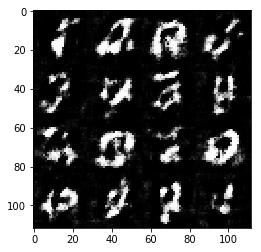

Epoch 1/2... Discriminator Loss: 0.5944... Generator Loss: 2.9858
Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 2.5011
Epoch 1/2... Discriminator Loss: 0.6167... Generator Loss: 3.0602
Epoch 1/2... Discriminator Loss: 0.6156... Generator Loss: 2.5156
Epoch 1/2... Discriminator Loss: 0.5752... Generator Loss: 2.5803
Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 2.7336
Epoch 1/2... Discriminator Loss: 0.5806... Generator Loss: 2.7275
Epoch 1/2... Discriminator Loss: 0.6137... Generator Loss: 2.6083
Epoch 1/2... Discriminator Loss: 0.6198... Generator Loss: 2.4118
Epoch 1/2... Discriminator Loss: 0.6501... Generator Loss: 2.0055


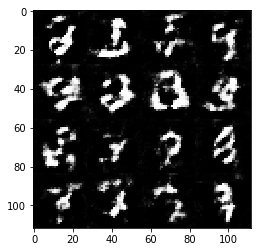

Epoch 1/2... Discriminator Loss: 0.6619... Generator Loss: 2.2658
Epoch 1/2... Discriminator Loss: 0.6155... Generator Loss: 2.5966
Epoch 1/2... Discriminator Loss: 0.5780... Generator Loss: 3.2594
Epoch 1/2... Discriminator Loss: 0.5685... Generator Loss: 3.4639
Epoch 1/2... Discriminator Loss: 0.6708... Generator Loss: 2.6036
Epoch 1/2... Discriminator Loss: 0.5772... Generator Loss: 2.9101
Epoch 1/2... Discriminator Loss: 0.6715... Generator Loss: 2.2379
Epoch 1/2... Discriminator Loss: 0.5837... Generator Loss: 2.9408
Epoch 1/2... Discriminator Loss: 0.6064... Generator Loss: 2.7095
Epoch 1/2... Discriminator Loss: 0.6380... Generator Loss: 2.4066


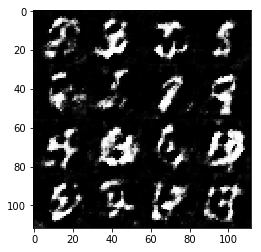

Epoch 1/2... Discriminator Loss: 0.5749... Generator Loss: 3.2044
Epoch 1/2... Discriminator Loss: 0.6254... Generator Loss: 3.5452
Epoch 1/2... Discriminator Loss: 0.5892... Generator Loss: 3.2374
Epoch 1/2... Discriminator Loss: 0.7015... Generator Loss: 2.1361
Epoch 1/2... Discriminator Loss: 0.5657... Generator Loss: 2.9982
Epoch 1/2... Discriminator Loss: 0.5728... Generator Loss: 3.4896
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 2.8718
Epoch 1/2... Discriminator Loss: 0.5630... Generator Loss: 3.0678
Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 2.5014
Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 3.2987


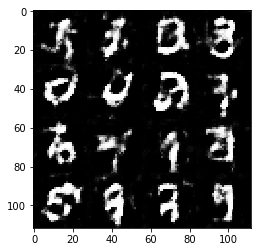

Epoch 1/2... Discriminator Loss: 0.6058... Generator Loss: 3.4497
Epoch 1/2... Discriminator Loss: 0.6240... Generator Loss: 3.9604
Epoch 1/2... Discriminator Loss: 0.6334... Generator Loss: 2.3880
Epoch 1/2... Discriminator Loss: 0.6093... Generator Loss: 2.6209
Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 3.6770
Epoch 1/2... Discriminator Loss: 0.5564... Generator Loss: 3.3268
Epoch 1/2... Discriminator Loss: 0.5744... Generator Loss: 3.2541
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 5.5112
Epoch 1/2... Discriminator Loss: 0.5759... Generator Loss: 2.9992
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 3.1171


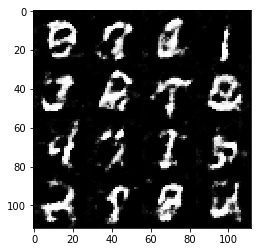

Epoch 1/2... Discriminator Loss: 0.5846... Generator Loss: 2.7899
Epoch 1/2... Discriminator Loss: 0.5878... Generator Loss: 2.7861
Epoch 1/2... Discriminator Loss: 0.6221... Generator Loss: 2.2957
Epoch 1/2... Discriminator Loss: 0.6186... Generator Loss: 3.9788
Epoch 1/2... Discriminator Loss: 0.6354... Generator Loss: 2.2781
Epoch 1/2... Discriminator Loss: 0.6111... Generator Loss: 2.4637
Epoch 1/2... Discriminator Loss: 0.7180... Generator Loss: 1.9238
Epoch 1/2... Discriminator Loss: 0.5831... Generator Loss: 3.7088
Epoch 1/2... Discriminator Loss: 0.5527... Generator Loss: 2.9729
Epoch 1/2... Discriminator Loss: 0.6090... Generator Loss: 2.7290


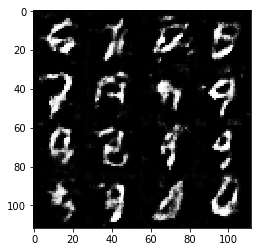

Epoch 1/2... Discriminator Loss: 0.6448... Generator Loss: 2.5148
Epoch 1/2... Discriminator Loss: 0.6523... Generator Loss: 3.4896
Epoch 1/2... Discriminator Loss: 0.6361... Generator Loss: 2.1479
Epoch 1/2... Discriminator Loss: 0.6139... Generator Loss: 2.6206
Epoch 1/2... Discriminator Loss: 0.6162... Generator Loss: 2.4987
Epoch 1/2... Discriminator Loss: 0.5930... Generator Loss: 2.4167
Epoch 1/2... Discriminator Loss: 0.5541... Generator Loss: 3.3714
Epoch 1/2... Discriminator Loss: 0.8901... Generator Loss: 5.5349
Epoch 1/2... Discriminator Loss: 0.5699... Generator Loss: 2.8888
Epoch 1/2... Discriminator Loss: 0.5880... Generator Loss: 2.9115


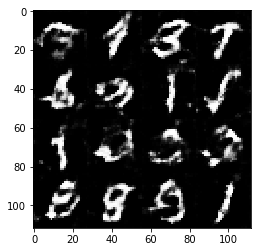

Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 3.6284
Epoch 1/2... Discriminator Loss: 0.6357... Generator Loss: 3.1848
Epoch 1/2... Discriminator Loss: 0.5806... Generator Loss: 2.6153
Epoch 1/2... Discriminator Loss: 0.5687... Generator Loss: 2.7933
Epoch 1/2... Discriminator Loss: 0.6014... Generator Loss: 2.6860
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 2.4651
Epoch 1/2... Discriminator Loss: 0.6480... Generator Loss: 2.1437
Epoch 1/2... Discriminator Loss: 0.5864... Generator Loss: 2.7961
Epoch 1/2... Discriminator Loss: 0.5514... Generator Loss: 2.9765
Epoch 1/2... Discriminator Loss: 0.5962... Generator Loss: 2.8050


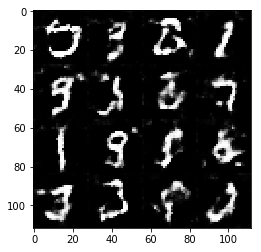

Epoch 1/2... Discriminator Loss: 0.6130... Generator Loss: 3.4794
Epoch 1/2... Discriminator Loss: 0.5841... Generator Loss: 3.5662
Epoch 1/2... Discriminator Loss: 0.5768... Generator Loss: 2.7708
Epoch 1/2... Discriminator Loss: 0.6609... Generator Loss: 4.0542
Epoch 1/2... Discriminator Loss: 0.6798... Generator Loss: 4.0468
Epoch 1/2... Discriminator Loss: 0.5732... Generator Loss: 2.9261
Epoch 1/2... Discriminator Loss: 0.6597... Generator Loss: 2.3346
Epoch 1/2... Discriminator Loss: 0.5902... Generator Loss: 2.5653
Epoch 1/2... Discriminator Loss: 0.6394... Generator Loss: 2.5034
Epoch 1/2... Discriminator Loss: 0.6030... Generator Loss: 2.5659


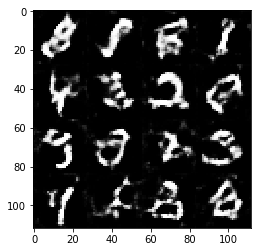

Epoch 1/2... Discriminator Loss: 0.6385... Generator Loss: 3.2461
Epoch 1/2... Discriminator Loss: 0.6180... Generator Loss: 2.7099
Epoch 1/2... Discriminator Loss: 0.5867... Generator Loss: 2.8976
Epoch 1/2... Discriminator Loss: 0.6264... Generator Loss: 2.2722
Epoch 1/2... Discriminator Loss: 0.6579... Generator Loss: 4.1108
Epoch 1/2... Discriminator Loss: 0.5933... Generator Loss: 2.6701
Epoch 1/2... Discriminator Loss: 0.5837... Generator Loss: 3.0046
Epoch 1/2... Discriminator Loss: 0.5913... Generator Loss: 3.0294
Epoch 1/2... Discriminator Loss: 0.5654... Generator Loss: 3.0532
Epoch 1/2... Discriminator Loss: 0.6172... Generator Loss: 3.3829


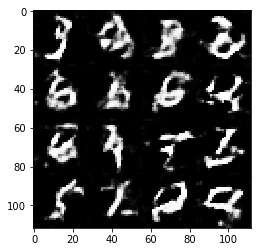

Epoch 1/2... Discriminator Loss: 0.7123... Generator Loss: 4.2448
Epoch 1/2... Discriminator Loss: 0.5970... Generator Loss: 2.4662
Epoch 1/2... Discriminator Loss: 0.5956... Generator Loss: 2.7094
Epoch 1/2... Discriminator Loss: 0.5624... Generator Loss: 2.5957
Epoch 1/2... Discriminator Loss: 0.5859... Generator Loss: 2.6120
Epoch 1/2... Discriminator Loss: 0.5902... Generator Loss: 2.8144
Epoch 1/2... Discriminator Loss: 0.7393... Generator Loss: 4.0904
Epoch 1/2... Discriminator Loss: 0.5860... Generator Loss: 2.9786
Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 3.1011
Epoch 1/2... Discriminator Loss: 0.6012... Generator Loss: 3.0712


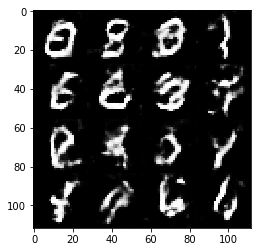

Epoch 1/2... Discriminator Loss: 0.5642... Generator Loss: 2.9343
Epoch 1/2... Discriminator Loss: 0.6768... Generator Loss: 3.9402
Epoch 1/2... Discriminator Loss: 0.6169... Generator Loss: 2.4667
Epoch 1/2... Discriminator Loss: 0.7062... Generator Loss: 4.5534
Epoch 1/2... Discriminator Loss: 0.5915... Generator Loss: 2.7988
Epoch 1/2... Discriminator Loss: 0.6201... Generator Loss: 3.6448
Epoch 1/2... Discriminator Loss: 0.6453... Generator Loss: 2.3998
Epoch 1/2... Discriminator Loss: 0.5551... Generator Loss: 3.1075
Epoch 1/2... Discriminator Loss: 0.5807... Generator Loss: 2.7847
Epoch 1/2... Discriminator Loss: 0.6293... Generator Loss: 2.4790


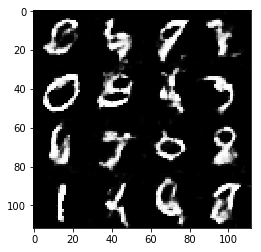

Epoch 1/2... Discriminator Loss: 0.5641... Generator Loss: 2.8633
Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 2.1113
Epoch 1/2... Discriminator Loss: 0.5691... Generator Loss: 2.9739
Epoch 1/2... Discriminator Loss: 0.5914... Generator Loss: 2.5503
Epoch 1/2... Discriminator Loss: 0.5764... Generator Loss: 3.3520
Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 2.9324
Epoch 1/2... Discriminator Loss: 0.5732... Generator Loss: 2.7390
Epoch 1/2... Discriminator Loss: 0.6890... Generator Loss: 3.9272
Epoch 1/2... Discriminator Loss: 0.5720... Generator Loss: 2.9286
Epoch 1/2... Discriminator Loss: 0.6481... Generator Loss: 3.6356


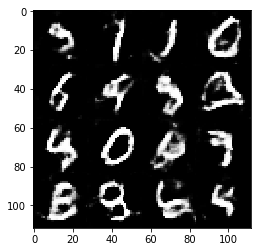

Epoch 1/2... Discriminator Loss: 0.6177... Generator Loss: 2.4216
Epoch 1/2... Discriminator Loss: 0.5747... Generator Loss: 3.4765
Epoch 1/2... Discriminator Loss: 0.6616... Generator Loss: 4.5201
Epoch 1/2... Discriminator Loss: 0.5793... Generator Loss: 3.4343
Epoch 1/2... Discriminator Loss: 0.5766... Generator Loss: 2.6383
Epoch 1/2... Discriminator Loss: 0.5857... Generator Loss: 2.6264
Epoch 1/2... Discriminator Loss: 0.5792... Generator Loss: 2.9061
Epoch 1/2... Discriminator Loss: 0.5482... Generator Loss: 3.2877
Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 3.2069
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 2.4318


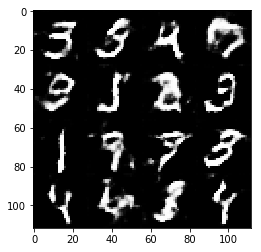

Epoch 1/2... Discriminator Loss: 0.5514... Generator Loss: 3.4649
Epoch 1/2... Discriminator Loss: 0.5629... Generator Loss: 2.7143
Epoch 1/2... Discriminator Loss: 0.6086... Generator Loss: 2.3067
Epoch 1/2... Discriminator Loss: 0.5997... Generator Loss: 2.4453
Epoch 1/2... Discriminator Loss: 0.6062... Generator Loss: 2.7262
Epoch 1/2... Discriminator Loss: 0.6213... Generator Loss: 2.3464
Epoch 1/2... Discriminator Loss: 0.5519... Generator Loss: 3.5292
Epoch 1/2... Discriminator Loss: 0.6095... Generator Loss: 2.8941
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 2.8999
Epoch 1/2... Discriminator Loss: 0.6582... Generator Loss: 2.3217


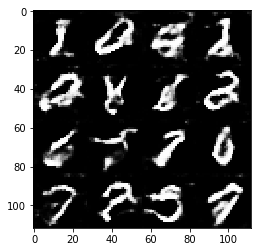

Epoch 1/2... Discriminator Loss: 0.6305... Generator Loss: 2.7371
Epoch 1/2... Discriminator Loss: 0.6238... Generator Loss: 2.3447
Epoch 1/2... Discriminator Loss: 0.5642... Generator Loss: 3.1043
Epoch 1/2... Discriminator Loss: 0.5646... Generator Loss: 2.7863
Epoch 1/2... Discriminator Loss: 0.6140... Generator Loss: 2.5217
Epoch 1/2... Discriminator Loss: 0.6659... Generator Loss: 4.0489
Epoch 1/2... Discriminator Loss: 0.5867... Generator Loss: 3.5590
Epoch 1/2... Discriminator Loss: 0.5635... Generator Loss: 3.5598
Epoch 1/2... Discriminator Loss: 0.5624... Generator Loss: 3.8202
Epoch 1/2... Discriminator Loss: 0.5566... Generator Loss: 3.2586


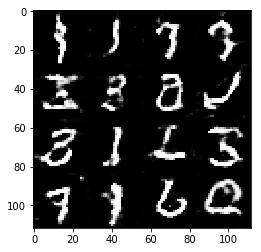

Epoch 1/2... Discriminator Loss: 0.5482... Generator Loss: 3.3812
Epoch 1/2... Discriminator Loss: 0.5709... Generator Loss: 2.9865
Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 3.5774
Epoch 1/2... Discriminator Loss: 0.8477... Generator Loss: 4.7501
Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 2.8071
Epoch 1/2... Discriminator Loss: 0.5517... Generator Loss: 3.1919
Epoch 1/2... Discriminator Loss: 0.5475... Generator Loss: 3.1553
Epoch 1/2... Discriminator Loss: 0.5474... Generator Loss: 3.0922
Epoch 1/2... Discriminator Loss: 0.6019... Generator Loss: 2.6722
Epoch 1/2... Discriminator Loss: 0.7969... Generator Loss: 4.5524


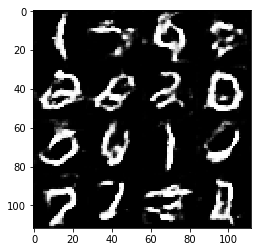

Epoch 1/2... Discriminator Loss: 0.5753... Generator Loss: 2.8112
Epoch 1/2... Discriminator Loss: 0.5996... Generator Loss: 2.3437
Epoch 1/2... Discriminator Loss: 0.6226... Generator Loss: 3.6346
Epoch 1/2... Discriminator Loss: 0.6035... Generator Loss: 2.4092
Epoch 1/2... Discriminator Loss: 0.6504... Generator Loss: 4.0631
Epoch 1/2... Discriminator Loss: 0.6367... Generator Loss: 2.3878
Epoch 1/2... Discriminator Loss: 0.5521... Generator Loss: 3.2395
Epoch 1/2... Discriminator Loss: 0.5903... Generator Loss: 3.0626
Epoch 1/2... Discriminator Loss: 0.5546... Generator Loss: 3.2708
Epoch 1/2... Discriminator Loss: 0.5619... Generator Loss: 3.0745


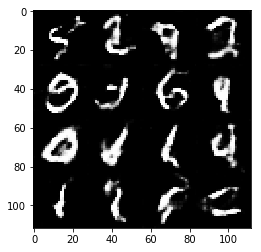

Epoch 1/2... Discriminator Loss: 0.7191... Generator Loss: 4.3523
Epoch 1/2... Discriminator Loss: 0.6545... Generator Loss: 3.9484
Epoch 1/2... Discriminator Loss: 0.6741... Generator Loss: 2.2363
Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 2.5323
Epoch 1/2... Discriminator Loss: 0.5593... Generator Loss: 2.8385
Epoch 1/2... Discriminator Loss: 0.6554... Generator Loss: 2.5437
Epoch 1/2... Discriminator Loss: 0.5668... Generator Loss: 2.8798
Epoch 1/2... Discriminator Loss: 0.5541... Generator Loss: 3.1769
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 3.3604
Epoch 1/2... Discriminator Loss: 0.5552... Generator Loss: 3.0761


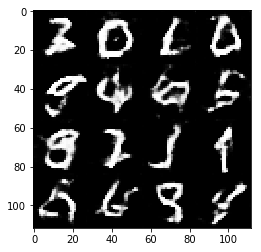

Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 2.8305
Epoch 1/2... Discriminator Loss: 0.5795... Generator Loss: 2.9700
Epoch 1/2... Discriminator Loss: 0.5724... Generator Loss: 4.0986
Epoch 1/2... Discriminator Loss: 0.5622... Generator Loss: 3.1367
Epoch 1/2... Discriminator Loss: 0.6361... Generator Loss: 2.6242
Epoch 1/2... Discriminator Loss: 0.5628... Generator Loss: 3.2576
Epoch 1/2... Discriminator Loss: 0.5859... Generator Loss: 2.5029
Epoch 1/2... Discriminator Loss: 0.5719... Generator Loss: 3.2266
Epoch 1/2... Discriminator Loss: 0.5600... Generator Loss: 3.2319
Epoch 1/2... Discriminator Loss: 0.5653... Generator Loss: 3.9625


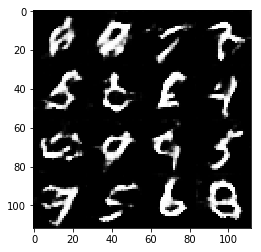

Epoch 1/2... Discriminator Loss: 0.5517... Generator Loss: 3.2652
Epoch 1/2... Discriminator Loss: 0.9114... Generator Loss: 5.4906
Epoch 1/2... Discriminator Loss: 0.5971... Generator Loss: 2.6840
Epoch 1/2... Discriminator Loss: 0.5756... Generator Loss: 3.6865
Epoch 1/2... Discriminator Loss: 0.6309... Generator Loss: 3.8754
Epoch 1/2... Discriminator Loss: 0.6400... Generator Loss: 3.6380
Epoch 1/2... Discriminator Loss: 0.5806... Generator Loss: 2.7406
Epoch 1/2... Discriminator Loss: 0.5624... Generator Loss: 3.3539
Epoch 1/2... Discriminator Loss: 0.5577... Generator Loss: 3.2005
Epoch 1/2... Discriminator Loss: 0.6780... Generator Loss: 4.1177


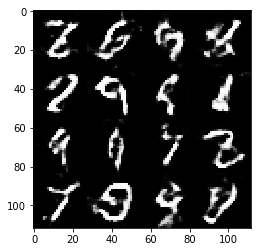

Epoch 1/2... Discriminator Loss: 0.5804... Generator Loss: 3.1142
Epoch 1/2... Discriminator Loss: 0.5453... Generator Loss: 3.4259
Epoch 1/2... Discriminator Loss: 0.5601... Generator Loss: 3.2146
Epoch 1/2... Discriminator Loss: 0.5592... Generator Loss: 3.0180
Epoch 1/2... Discriminator Loss: 0.5657... Generator Loss: 3.0820
Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 3.0381
Epoch 1/2... Discriminator Loss: 0.5720... Generator Loss: 2.7126
Epoch 1/2... Discriminator Loss: 0.5622... Generator Loss: 3.5574
Epoch 1/2... Discriminator Loss: 0.6737... Generator Loss: 2.3821
Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 2.7369


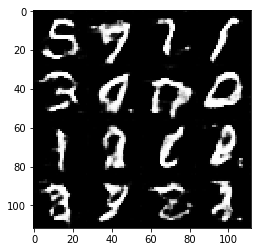

Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 5.3365
Epoch 1/2... Discriminator Loss: 0.5762... Generator Loss: 2.7189
Epoch 1/2... Discriminator Loss: 0.6125... Generator Loss: 3.5169
Epoch 1/2... Discriminator Loss: 0.5838... Generator Loss: 3.4154
Epoch 1/2... Discriminator Loss: 0.5669... Generator Loss: 3.0560
Epoch 1/2... Discriminator Loss: 0.6070... Generator Loss: 3.9938
Epoch 1/2... Discriminator Loss: 0.6145... Generator Loss: 3.9491
Epoch 1/2... Discriminator Loss: 0.5849... Generator Loss: 3.0184
Epoch 1/2... Discriminator Loss: 0.5462... Generator Loss: 3.7270
Epoch 1/2... Discriminator Loss: 0.5755... Generator Loss: 2.7816


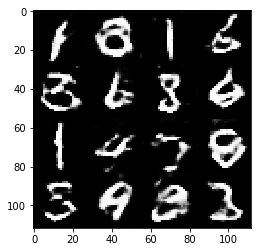

Epoch 1/2... Discriminator Loss: 0.5982... Generator Loss: 3.3420
Epoch 1/2... Discriminator Loss: 0.6136... Generator Loss: 2.5199
Epoch 1/2... Discriminator Loss: 0.6081... Generator Loss: 2.8841
Epoch 1/2... Discriminator Loss: 0.5317... Generator Loss: 3.3635
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 2.6611
Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 3.3997
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 2.7593
Epoch 1/2... Discriminator Loss: 0.5889... Generator Loss: 2.9396
Epoch 1/2... Discriminator Loss: 0.5633... Generator Loss: 2.9516
Epoch 1/2... Discriminator Loss: 0.5367... Generator Loss: 3.5614


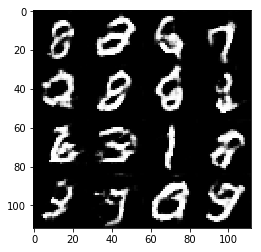

Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 2.8376
Epoch 1/2... Discriminator Loss: 0.5636... Generator Loss: 3.1082
Epoch 1/2... Discriminator Loss: 0.6431... Generator Loss: 2.5127
Epoch 1/2... Discriminator Loss: 0.5927... Generator Loss: 3.3664
Epoch 1/2... Discriminator Loss: 0.5398... Generator Loss: 3.1432
Epoch 1/2... Discriminator Loss: 0.5913... Generator Loss: 2.7199
Epoch 1/2... Discriminator Loss: 0.5695... Generator Loss: 2.8026
Epoch 1/2... Discriminator Loss: 0.5341... Generator Loss: 3.6755
Epoch 1/2... Discriminator Loss: 0.5426... Generator Loss: 3.4347
Epoch 1/2... Discriminator Loss: 0.5886... Generator Loss: 2.8883


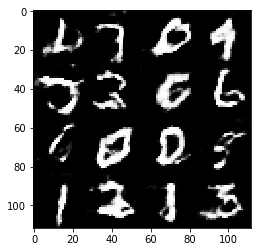

Epoch 1/2... Discriminator Loss: 0.5540... Generator Loss: 3.5361
Epoch 1/2... Discriminator Loss: 0.5701... Generator Loss: 3.1757
Epoch 1/2... Discriminator Loss: 0.5497... Generator Loss: 3.5584
Epoch 1/2... Discriminator Loss: 0.5522... Generator Loss: 3.3867
Epoch 1/2... Discriminator Loss: 0.5609... Generator Loss: 3.7066
Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 2.9616
Epoch 1/2... Discriminator Loss: 0.5753... Generator Loss: 2.9174
Epoch 1/2... Discriminator Loss: 0.5293... Generator Loss: 3.8137
Epoch 1/2... Discriminator Loss: 0.5614... Generator Loss: 2.9000
Epoch 1/2... Discriminator Loss: 0.5616... Generator Loss: 3.4725


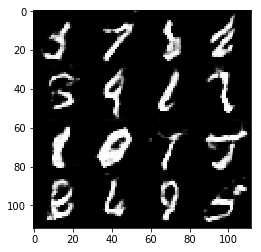

Epoch 1/2... Discriminator Loss: 0.5508... Generator Loss: 3.6786
Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 3.7011
Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 2.9915
Epoch 1/2... Discriminator Loss: 0.6166... Generator Loss: 2.5690
Epoch 1/2... Discriminator Loss: 0.5424... Generator Loss: 3.1536
Epoch 1/2... Discriminator Loss: 0.5535... Generator Loss: 3.4162
Epoch 1/2... Discriminator Loss: 0.6116... Generator Loss: 2.9093
Epoch 1/2... Discriminator Loss: 0.6379... Generator Loss: 2.8111
Epoch 1/2... Discriminator Loss: 0.5657... Generator Loss: 3.2667
Epoch 1/2... Discriminator Loss: 0.6174... Generator Loss: 4.1503


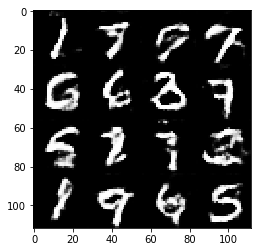

Epoch 1/2... Discriminator Loss: 0.5492... Generator Loss: 3.4965
Epoch 1/2... Discriminator Loss: 0.5424... Generator Loss: 3.0742
Epoch 1/2... Discriminator Loss: 0.5899... Generator Loss: 3.7316
Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 3.0900
Epoch 1/2... Discriminator Loss: 0.5598... Generator Loss: 2.9431
Epoch 1/2... Discriminator Loss: 0.5765... Generator Loss: 4.3907
Epoch 1/2... Discriminator Loss: 0.5381... Generator Loss: 3.3817
Epoch 1/2... Discriminator Loss: 0.5848... Generator Loss: 3.7450
Epoch 1/2... Discriminator Loss: 0.5400... Generator Loss: 3.0871
Epoch 1/2... Discriminator Loss: 0.5674... Generator Loss: 3.3766


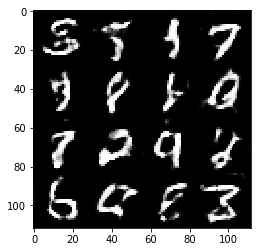

Epoch 1/2... Discriminator Loss: 0.5677... Generator Loss: 3.2005
Epoch 1/2... Discriminator Loss: 0.5426... Generator Loss: 3.0166
Epoch 1/2... Discriminator Loss: 0.6506... Generator Loss: 2.3248
Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 3.2027
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 3.5387
Epoch 1/2... Discriminator Loss: 0.5875... Generator Loss: 3.0928
Epoch 1/2... Discriminator Loss: 0.5465... Generator Loss: 3.2857
Epoch 1/2... Discriminator Loss: 0.5983... Generator Loss: 3.6524
Epoch 1/2... Discriminator Loss: 0.5324... Generator Loss: 3.4033
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 3.1960


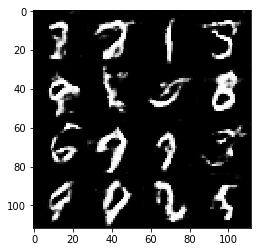

Epoch 1/2... Discriminator Loss: 0.6310... Generator Loss: 2.6808
Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 2.1617
Epoch 1/2... Discriminator Loss: 0.5698... Generator Loss: 3.1102
Epoch 1/2... Discriminator Loss: 0.5746... Generator Loss: 3.4460
Epoch 1/2... Discriminator Loss: 0.5485... Generator Loss: 3.6879
Epoch 1/2... Discriminator Loss: 0.5671... Generator Loss: 3.4450
Epoch 1/2... Discriminator Loss: 0.5799... Generator Loss: 3.7261
Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 3.0045
Epoch 1/2... Discriminator Loss: 0.5312... Generator Loss: 3.7447
Epoch 1/2... Discriminator Loss: 0.5342... Generator Loss: 3.4532


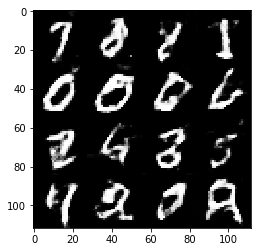

Epoch 1/2... Discriminator Loss: 0.5457... Generator Loss: 3.7466
Epoch 1/2... Discriminator Loss: 0.5367... Generator Loss: 3.6252
Epoch 1/2... Discriminator Loss: 0.7381... Generator Loss: 2.2607
Epoch 1/2... Discriminator Loss: 0.5571... Generator Loss: 2.9303
Epoch 1/2... Discriminator Loss: 0.5361... Generator Loss: 3.6560
Epoch 1/2... Discriminator Loss: 0.5568... Generator Loss: 2.8595
Epoch 1/2... Discriminator Loss: 0.5456... Generator Loss: 3.4989
Epoch 1/2... Discriminator Loss: 0.5624... Generator Loss: 3.5879
Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 3.1103
Epoch 1/2... Discriminator Loss: 0.6667... Generator Loss: 2.4952


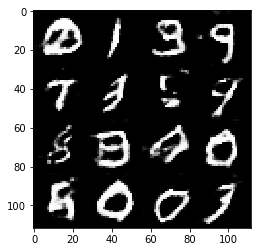

Epoch 1/2... Discriminator Loss: 0.5677... Generator Loss: 4.7558
Epoch 1/2... Discriminator Loss: 0.5383... Generator Loss: 3.8713
Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 5.0316
Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 3.5471
Epoch 1/2... Discriminator Loss: 0.5882... Generator Loss: 2.9608
Epoch 1/2... Discriminator Loss: 0.5405... Generator Loss: 3.9728
Epoch 1/2... Discriminator Loss: 0.5382... Generator Loss: 3.8992
Epoch 1/2... Discriminator Loss: 0.5611... Generator Loss: 3.2208
Epoch 1/2... Discriminator Loss: 0.5339... Generator Loss: 3.8619
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 3.6772


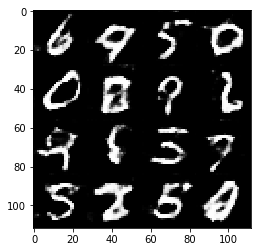

Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 3.7351
Epoch 1/2... Discriminator Loss: 0.5265... Generator Loss: 3.8596
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 2.8036
Epoch 1/2... Discriminator Loss: 0.5839... Generator Loss: 3.3732
Epoch 1/2... Discriminator Loss: 0.5614... Generator Loss: 3.2746
Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 2.6531
Epoch 1/2... Discriminator Loss: 0.6022... Generator Loss: 3.0080
Epoch 1/2... Discriminator Loss: 0.5373... Generator Loss: 3.3482
Epoch 1/2... Discriminator Loss: 0.6602... Generator Loss: 4.3687
Epoch 1/2... Discriminator Loss: 0.5428... Generator Loss: 3.3217


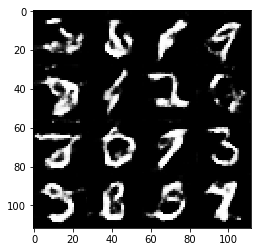

Epoch 1/2... Discriminator Loss: 0.5639... Generator Loss: 3.0875
Epoch 1/2... Discriminator Loss: 0.5715... Generator Loss: 3.6849
Epoch 1/2... Discriminator Loss: 0.5404... Generator Loss: 3.3042
Epoch 1/2... Discriminator Loss: 0.5851... Generator Loss: 3.1649
Epoch 1/2... Discriminator Loss: 0.5715... Generator Loss: 2.7916
Epoch 1/2... Discriminator Loss: 0.5588... Generator Loss: 4.1329
Epoch 1/2... Discriminator Loss: 0.6689... Generator Loss: 4.1254
Epoch 1/2... Discriminator Loss: 0.6375... Generator Loss: 3.9362
Epoch 1/2... Discriminator Loss: 0.5654... Generator Loss: 3.9564
Epoch 1/2... Discriminator Loss: 0.5550... Generator Loss: 3.6795


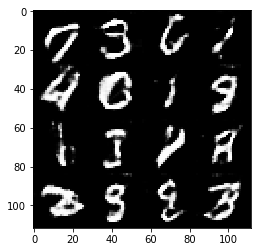

Epoch 1/2... Discriminator Loss: 0.5935... Generator Loss: 3.5639
Epoch 1/2... Discriminator Loss: 0.5524... Generator Loss: 4.0366
Epoch 1/2... Discriminator Loss: 0.5637... Generator Loss: 2.6261
Epoch 1/2... Discriminator Loss: 0.5614... Generator Loss: 3.6624
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 2.9236
Epoch 1/2... Discriminator Loss: 0.5666... Generator Loss: 4.2429
Epoch 2/2... Discriminator Loss: 0.5407... Generator Loss: 3.3711
Epoch 2/2... Discriminator Loss: 0.5619... Generator Loss: 3.5843
Epoch 2/2... Discriminator Loss: 0.5460... Generator Loss: 3.5716
Epoch 2/2... Discriminator Loss: 0.6207... Generator Loss: 2.8914


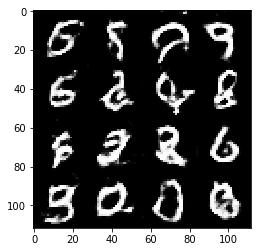

Epoch 2/2... Discriminator Loss: 0.5440... Generator Loss: 3.3495
Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 3.1818
Epoch 2/2... Discriminator Loss: 0.6108... Generator Loss: 4.0073
Epoch 2/2... Discriminator Loss: 0.5561... Generator Loss: 3.1428
Epoch 2/2... Discriminator Loss: 0.6552... Generator Loss: 2.6674
Epoch 2/2... Discriminator Loss: 0.5592... Generator Loss: 3.3239
Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 3.0592
Epoch 2/2... Discriminator Loss: 0.5779... Generator Loss: 2.7740
Epoch 2/2... Discriminator Loss: 0.5453... Generator Loss: 3.4041
Epoch 2/2... Discriminator Loss: 0.6153... Generator Loss: 2.6716


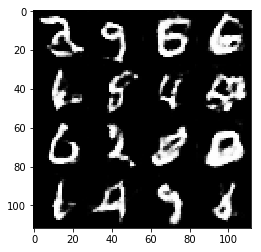

Epoch 2/2... Discriminator Loss: 0.5493... Generator Loss: 2.7600
Epoch 2/2... Discriminator Loss: 0.5845... Generator Loss: 3.2987
Epoch 2/2... Discriminator Loss: 0.6089... Generator Loss: 4.4972
Epoch 2/2... Discriminator Loss: 0.5446... Generator Loss: 3.1809
Epoch 2/2... Discriminator Loss: 0.5563... Generator Loss: 3.4304
Epoch 2/2... Discriminator Loss: 0.5404... Generator Loss: 3.8799
Epoch 2/2... Discriminator Loss: 0.5278... Generator Loss: 3.7568
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 2.6988
Epoch 2/2... Discriminator Loss: 0.5550... Generator Loss: 3.4664
Epoch 2/2... Discriminator Loss: 0.5341... Generator Loss: 3.6503


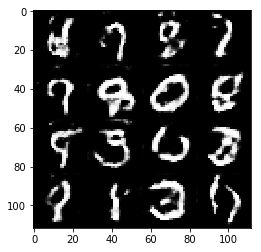

Epoch 2/2... Discriminator Loss: 0.5587... Generator Loss: 3.4003
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 3.1465
Epoch 2/2... Discriminator Loss: 0.6118... Generator Loss: 3.0667
Epoch 2/2... Discriminator Loss: 0.5657... Generator Loss: 3.4343
Epoch 2/2... Discriminator Loss: 0.5454... Generator Loss: 3.3425
Epoch 2/2... Discriminator Loss: 0.5527... Generator Loss: 4.3797
Epoch 2/2... Discriminator Loss: 0.5407... Generator Loss: 3.0985
Epoch 2/2... Discriminator Loss: 0.5305... Generator Loss: 3.5287
Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 3.4958
Epoch 2/2... Discriminator Loss: 0.7130... Generator Loss: 5.2585


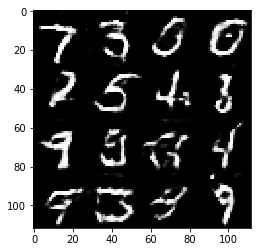

Epoch 2/2... Discriminator Loss: 0.5434... Generator Loss: 3.3244
Epoch 2/2... Discriminator Loss: 0.5473... Generator Loss: 3.2907
Epoch 2/2... Discriminator Loss: 0.7304... Generator Loss: 4.7435
Epoch 2/2... Discriminator Loss: 0.5181... Generator Loss: 3.5693
Epoch 2/2... Discriminator Loss: 0.5408... Generator Loss: 3.3934
Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 3.6616
Epoch 2/2... Discriminator Loss: 0.5305... Generator Loss: 3.4639
Epoch 2/2... Discriminator Loss: 0.5696... Generator Loss: 4.6222
Epoch 2/2... Discriminator Loss: 0.5725... Generator Loss: 3.9262
Epoch 2/2... Discriminator Loss: 0.5692... Generator Loss: 3.3751


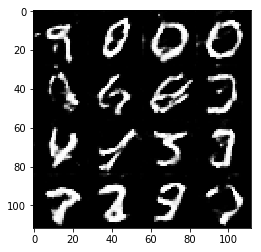

Epoch 2/2... Discriminator Loss: 0.5307... Generator Loss: 3.4711
Epoch 2/2... Discriminator Loss: 0.5664... Generator Loss: 3.0704
Epoch 2/2... Discriminator Loss: 0.5472... Generator Loss: 3.4214
Epoch 2/2... Discriminator Loss: 0.6102... Generator Loss: 3.0478
Epoch 2/2... Discriminator Loss: 0.5287... Generator Loss: 3.8923
Epoch 2/2... Discriminator Loss: 0.6043... Generator Loss: 2.6158
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 3.4148
Epoch 2/2... Discriminator Loss: 0.5291... Generator Loss: 4.3903
Epoch 2/2... Discriminator Loss: 0.5609... Generator Loss: 2.8875
Epoch 2/2... Discriminator Loss: 0.6193... Generator Loss: 4.2394


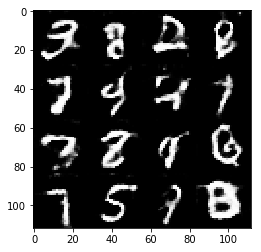

Epoch 2/2... Discriminator Loss: 0.5765... Generator Loss: 3.4815
Epoch 2/2... Discriminator Loss: 0.5498... Generator Loss: 3.3400
Epoch 2/2... Discriminator Loss: 0.5774... Generator Loss: 4.4305
Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 4.4984
Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 2.6138
Epoch 2/2... Discriminator Loss: 0.5421... Generator Loss: 3.2348
Epoch 2/2... Discriminator Loss: 0.5773... Generator Loss: 3.4305
Epoch 2/2... Discriminator Loss: 0.5213... Generator Loss: 3.3401
Epoch 2/2... Discriminator Loss: 0.5974... Generator Loss: 3.0307
Epoch 2/2... Discriminator Loss: 0.6286... Generator Loss: 4.0887


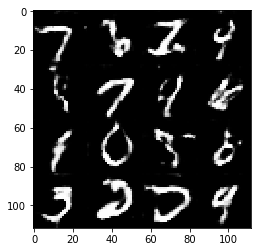

Epoch 2/2... Discriminator Loss: 0.8063... Generator Loss: 4.7745
Epoch 2/2... Discriminator Loss: 0.6048... Generator Loss: 2.6286
Epoch 2/2... Discriminator Loss: 0.5242... Generator Loss: 3.6146
Epoch 2/2... Discriminator Loss: 0.6519... Generator Loss: 3.5771
Epoch 2/2... Discriminator Loss: 0.5542... Generator Loss: 3.3073
Epoch 2/2... Discriminator Loss: 0.5338... Generator Loss: 3.3869
Epoch 2/2... Discriminator Loss: 0.5791... Generator Loss: 2.9320
Epoch 2/2... Discriminator Loss: 0.5531... Generator Loss: 3.6452
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 4.1451
Epoch 2/2... Discriminator Loss: 0.5320... Generator Loss: 3.7688


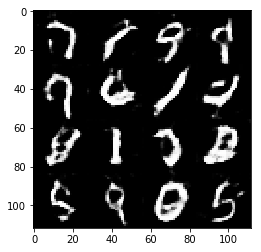

Epoch 2/2... Discriminator Loss: 0.5379... Generator Loss: 3.4295
Epoch 2/2... Discriminator Loss: 0.5375... Generator Loss: 3.5178
Epoch 2/2... Discriminator Loss: 0.5635... Generator Loss: 3.6025
Epoch 2/2... Discriminator Loss: 0.6014... Generator Loss: 2.6045
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 3.2693
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 3.3798
Epoch 2/2... Discriminator Loss: 0.6334... Generator Loss: 2.5350
Epoch 2/2... Discriminator Loss: 0.5692... Generator Loss: 2.8814
Epoch 2/2... Discriminator Loss: 0.6129... Generator Loss: 4.0687
Epoch 2/2... Discriminator Loss: 0.5568... Generator Loss: 3.0125


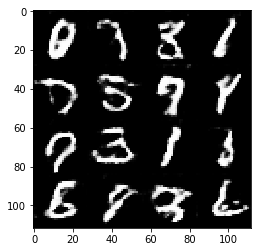

Epoch 2/2... Discriminator Loss: 0.7656... Generator Loss: 5.3680
Epoch 2/2... Discriminator Loss: 0.5951... Generator Loss: 2.5722
Epoch 2/2... Discriminator Loss: 0.5754... Generator Loss: 3.2227
Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 3.8970
Epoch 2/2... Discriminator Loss: 0.5834... Generator Loss: 3.9744
Epoch 2/2... Discriminator Loss: 0.6985... Generator Loss: 4.5669
Epoch 2/2... Discriminator Loss: 0.5512... Generator Loss: 3.6478
Epoch 2/2... Discriminator Loss: 0.6115... Generator Loss: 3.5401
Epoch 2/2... Discriminator Loss: 0.5434... Generator Loss: 3.9164
Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 2.7049


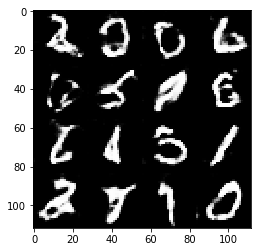

Epoch 2/2... Discriminator Loss: 0.5215... Generator Loss: 3.8583
Epoch 2/2... Discriminator Loss: 0.5555... Generator Loss: 3.2563
Epoch 2/2... Discriminator Loss: 0.5335... Generator Loss: 3.3234
Epoch 2/2... Discriminator Loss: 0.5674... Generator Loss: 2.9806
Epoch 2/2... Discriminator Loss: 0.5714... Generator Loss: 3.1649
Epoch 2/2... Discriminator Loss: 0.5520... Generator Loss: 3.8312
Epoch 2/2... Discriminator Loss: 0.5797... Generator Loss: 2.9274
Epoch 2/2... Discriminator Loss: 0.6026... Generator Loss: 4.4425
Epoch 2/2... Discriminator Loss: 0.5556... Generator Loss: 3.2051
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 3.1701


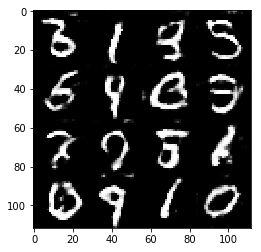

Epoch 2/2... Discriminator Loss: 0.6819... Generator Loss: 4.9313
Epoch 2/2... Discriminator Loss: 0.7052... Generator Loss: 4.6394
Epoch 2/2... Discriminator Loss: 0.5413... Generator Loss: 2.9631
Epoch 2/2... Discriminator Loss: 0.6037... Generator Loss: 4.7078
Epoch 2/2... Discriminator Loss: 0.5402... Generator Loss: 3.1441
Epoch 2/2... Discriminator Loss: 0.5271... Generator Loss: 3.6494
Epoch 2/2... Discriminator Loss: 0.5515... Generator Loss: 3.8526
Epoch 2/2... Discriminator Loss: 0.5845... Generator Loss: 4.6863
Epoch 2/2... Discriminator Loss: 0.5787... Generator Loss: 4.1200
Epoch 2/2... Discriminator Loss: 0.5742... Generator Loss: 4.1845


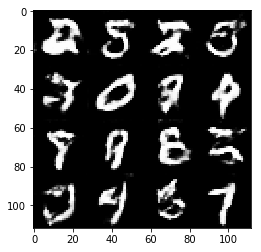

Epoch 2/2... Discriminator Loss: 0.5343... Generator Loss: 3.0235
Epoch 2/2... Discriminator Loss: 0.5315... Generator Loss: 4.2182
Epoch 2/2... Discriminator Loss: 0.5401... Generator Loss: 3.2981
Epoch 2/2... Discriminator Loss: 0.6130... Generator Loss: 2.7747
Epoch 2/2... Discriminator Loss: 0.5825... Generator Loss: 4.3254
Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 3.1741
Epoch 2/2... Discriminator Loss: 0.5247... Generator Loss: 3.7260
Epoch 2/2... Discriminator Loss: 0.6102... Generator Loss: 4.3394
Epoch 2/2... Discriminator Loss: 0.5667... Generator Loss: 4.1525
Epoch 2/2... Discriminator Loss: 0.5838... Generator Loss: 3.9396


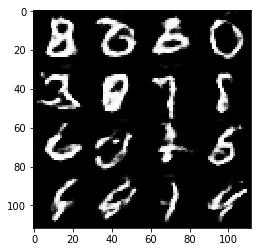

Epoch 2/2... Discriminator Loss: 0.5286... Generator Loss: 3.5723
Epoch 2/2... Discriminator Loss: 0.5439... Generator Loss: 3.9099
Epoch 2/2... Discriminator Loss: 0.5960... Generator Loss: 3.0530
Epoch 2/2... Discriminator Loss: 0.5567... Generator Loss: 4.0664
Epoch 2/2... Discriminator Loss: 0.5370... Generator Loss: 3.9380
Epoch 2/2... Discriminator Loss: 0.5211... Generator Loss: 3.3457
Epoch 2/2... Discriminator Loss: 0.5614... Generator Loss: 3.9583
Epoch 2/2... Discriminator Loss: 0.5691... Generator Loss: 3.1238
Epoch 2/2... Discriminator Loss: 0.6050... Generator Loss: 2.5601
Epoch 2/2... Discriminator Loss: 0.5484... Generator Loss: 4.0544


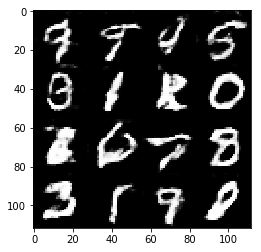

Epoch 2/2... Discriminator Loss: 0.5197... Generator Loss: 4.2208
Epoch 2/2... Discriminator Loss: 0.6225... Generator Loss: 4.2900
Epoch 2/2... Discriminator Loss: 0.5430... Generator Loss: 3.5105
Epoch 2/2... Discriminator Loss: 0.5436... Generator Loss: 3.5146
Epoch 2/2... Discriminator Loss: 0.5678... Generator Loss: 2.9683
Epoch 2/2... Discriminator Loss: 0.5834... Generator Loss: 2.8296
Epoch 2/2... Discriminator Loss: 0.5766... Generator Loss: 3.0741
Epoch 2/2... Discriminator Loss: 0.5255... Generator Loss: 3.4543
Epoch 2/2... Discriminator Loss: 0.5491... Generator Loss: 3.1238
Epoch 2/2... Discriminator Loss: 0.5666... Generator Loss: 4.0776


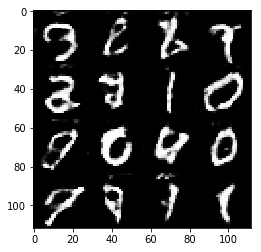

Epoch 2/2... Discriminator Loss: 0.5777... Generator Loss: 3.1958
Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 3.9800
Epoch 2/2... Discriminator Loss: 0.6535... Generator Loss: 3.2016
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 3.3966
Epoch 2/2... Discriminator Loss: 0.5188... Generator Loss: 3.9442
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 4.1994
Epoch 2/2... Discriminator Loss: 0.5493... Generator Loss: 3.3570
Epoch 2/2... Discriminator Loss: 0.5518... Generator Loss: 3.0745
Epoch 2/2... Discriminator Loss: 0.5419... Generator Loss: 3.4711
Epoch 2/2... Discriminator Loss: 0.5282... Generator Loss: 3.1963


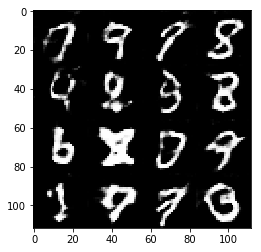

Epoch 2/2... Discriminator Loss: 0.5238... Generator Loss: 4.1185
Epoch 2/2... Discriminator Loss: 0.5290... Generator Loss: 3.5766
Epoch 2/2... Discriminator Loss: 0.6567... Generator Loss: 5.2268
Epoch 2/2... Discriminator Loss: 0.6122... Generator Loss: 3.0031
Epoch 2/2... Discriminator Loss: 0.5206... Generator Loss: 3.5022
Epoch 2/2... Discriminator Loss: 0.5420... Generator Loss: 3.5176
Epoch 2/2... Discriminator Loss: 0.5530... Generator Loss: 3.8494
Epoch 2/2... Discriminator Loss: 0.5454... Generator Loss: 4.2733
Epoch 2/2... Discriminator Loss: 0.5912... Generator Loss: 4.3702
Epoch 2/2... Discriminator Loss: 0.5462... Generator Loss: 3.6307


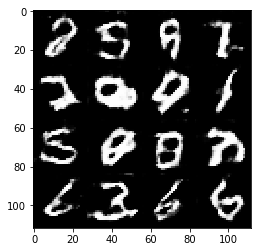

Epoch 2/2... Discriminator Loss: 0.5169... Generator Loss: 4.0399
Epoch 2/2... Discriminator Loss: 0.5312... Generator Loss: 4.1321
Epoch 2/2... Discriminator Loss: 0.5265... Generator Loss: 3.8990
Epoch 2/2... Discriminator Loss: 0.5505... Generator Loss: 3.2142
Epoch 2/2... Discriminator Loss: 0.5385... Generator Loss: 4.0297
Epoch 2/2... Discriminator Loss: 0.6207... Generator Loss: 4.3145
Epoch 2/2... Discriminator Loss: 0.5634... Generator Loss: 3.2194
Epoch 2/2... Discriminator Loss: 0.5404... Generator Loss: 3.7427
Epoch 2/2... Discriminator Loss: 0.5661... Generator Loss: 3.4422
Epoch 2/2... Discriminator Loss: 0.5448... Generator Loss: 4.0351


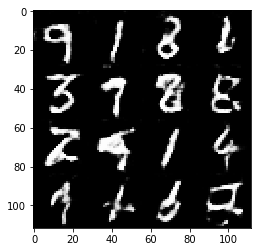

Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 3.9381
Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 5.6143
Epoch 2/2... Discriminator Loss: 0.6380... Generator Loss: 3.4252
Epoch 2/2... Discriminator Loss: 0.5208... Generator Loss: 3.6719
Epoch 2/2... Discriminator Loss: 0.5369... Generator Loss: 3.5438
Epoch 2/2... Discriminator Loss: 0.5574... Generator Loss: 3.1492
Epoch 2/2... Discriminator Loss: 0.5359... Generator Loss: 3.5089
Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 3.3894
Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 3.9804
Epoch 2/2... Discriminator Loss: 0.5599... Generator Loss: 3.0724


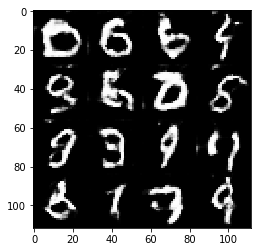

Epoch 2/2... Discriminator Loss: 0.5451... Generator Loss: 3.2803
Epoch 2/2... Discriminator Loss: 0.6201... Generator Loss: 4.5609
Epoch 2/2... Discriminator Loss: 0.5776... Generator Loss: 4.7865
Epoch 2/2... Discriminator Loss: 0.6072... Generator Loss: 4.5674
Epoch 2/2... Discriminator Loss: 0.5614... Generator Loss: 4.1834
Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 3.5541
Epoch 2/2... Discriminator Loss: 0.5350... Generator Loss: 4.0265
Epoch 2/2... Discriminator Loss: 0.5529... Generator Loss: 3.7744
Epoch 2/2... Discriminator Loss: 0.5604... Generator Loss: 3.5532
Epoch 2/2... Discriminator Loss: 0.5193... Generator Loss: 3.8440


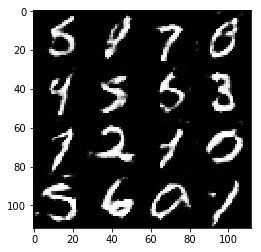

Epoch 2/2... Discriminator Loss: 0.5389... Generator Loss: 3.9263
Epoch 2/2... Discriminator Loss: 0.5345... Generator Loss: 3.7816
Epoch 2/2... Discriminator Loss: 0.5235... Generator Loss: 4.3462
Epoch 2/2... Discriminator Loss: 0.5410... Generator Loss: 3.6322
Epoch 2/2... Discriminator Loss: 0.5719... Generator Loss: 3.7210
Epoch 2/2... Discriminator Loss: 0.7644... Generator Loss: 4.4743
Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 3.7265
Epoch 2/2... Discriminator Loss: 0.5604... Generator Loss: 4.1129
Epoch 2/2... Discriminator Loss: 0.6567... Generator Loss: 2.9412
Epoch 2/2... Discriminator Loss: 0.5341... Generator Loss: 3.8296


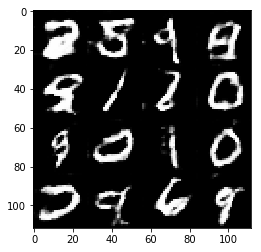

Epoch 2/2... Discriminator Loss: 0.5256... Generator Loss: 4.1869
Epoch 2/2... Discriminator Loss: 0.5278... Generator Loss: 4.0989
Epoch 2/2... Discriminator Loss: 0.5561... Generator Loss: 3.1734
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 3.0999
Epoch 2/2... Discriminator Loss: 0.5341... Generator Loss: 3.7429
Epoch 2/2... Discriminator Loss: 0.5985... Generator Loss: 4.1590
Epoch 2/2... Discriminator Loss: 0.5273... Generator Loss: 3.7480
Epoch 2/2... Discriminator Loss: 0.6053... Generator Loss: 3.2600
Epoch 2/2... Discriminator Loss: 0.5338... Generator Loss: 4.3110
Epoch 2/2... Discriminator Loss: 0.5201... Generator Loss: 3.9084


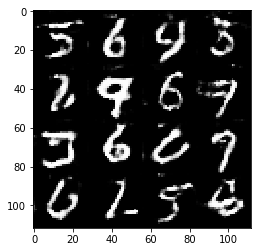

Epoch 2/2... Discriminator Loss: 0.5208... Generator Loss: 4.2441
Epoch 2/2... Discriminator Loss: 0.5451... Generator Loss: 3.4919
Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 3.0225
Epoch 2/2... Discriminator Loss: 0.5345... Generator Loss: 3.4734
Epoch 2/2... Discriminator Loss: 0.5370... Generator Loss: 3.7366
Epoch 2/2... Discriminator Loss: 0.5718... Generator Loss: 3.3110
Epoch 2/2... Discriminator Loss: 0.5723... Generator Loss: 3.5914
Epoch 2/2... Discriminator Loss: 0.5508... Generator Loss: 4.0791
Epoch 2/2... Discriminator Loss: 0.7727... Generator Loss: 4.5420
Epoch 2/2... Discriminator Loss: 0.5525... Generator Loss: 3.0352


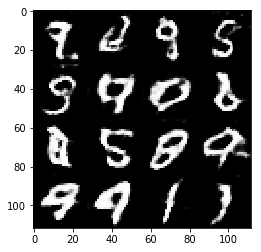

Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 3.2279
Epoch 2/2... Discriminator Loss: 0.5540... Generator Loss: 3.4686
Epoch 2/2... Discriminator Loss: 0.5278... Generator Loss: 3.3865
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 3.9874
Epoch 2/2... Discriminator Loss: 0.5283... Generator Loss: 3.4235
Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 4.0308
Epoch 2/2... Discriminator Loss: 0.5460... Generator Loss: 4.1545
Epoch 2/2... Discriminator Loss: 0.5352... Generator Loss: 3.5700
Epoch 2/2... Discriminator Loss: 0.5181... Generator Loss: 4.6062
Epoch 2/2... Discriminator Loss: 0.5626... Generator Loss: 4.6278


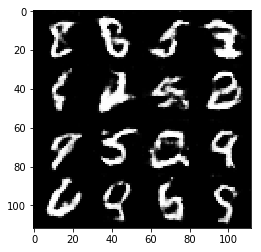

Epoch 2/2... Discriminator Loss: 0.5249... Generator Loss: 4.2767
Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 3.2880
Epoch 2/2... Discriminator Loss: 0.5147... Generator Loss: 4.0243
Epoch 2/2... Discriminator Loss: 0.5805... Generator Loss: 4.5220
Epoch 2/2... Discriminator Loss: 0.5513... Generator Loss: 3.2541
Epoch 2/2... Discriminator Loss: 0.5361... Generator Loss: 3.2308
Epoch 2/2... Discriminator Loss: 0.5159... Generator Loss: 4.2372
Epoch 2/2... Discriminator Loss: 0.5301... Generator Loss: 3.6317
Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 3.0679
Epoch 2/2... Discriminator Loss: 0.5321... Generator Loss: 4.1030


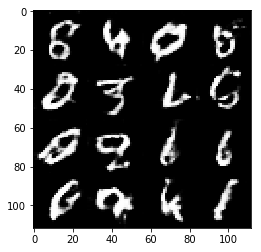

Epoch 2/2... Discriminator Loss: 0.5459... Generator Loss: 3.2035
Epoch 2/2... Discriminator Loss: 0.5403... Generator Loss: 3.5918
Epoch 2/2... Discriminator Loss: 0.5917... Generator Loss: 4.4631
Epoch 2/2... Discriminator Loss: 0.5849... Generator Loss: 2.6795
Epoch 2/2... Discriminator Loss: 0.5506... Generator Loss: 3.4901
Epoch 2/2... Discriminator Loss: 0.5190... Generator Loss: 3.8078
Epoch 2/2... Discriminator Loss: 0.5257... Generator Loss: 3.8124
Epoch 2/2... Discriminator Loss: 0.5369... Generator Loss: 3.5900
Epoch 2/2... Discriminator Loss: 0.5502... Generator Loss: 3.3574
Epoch 2/2... Discriminator Loss: 0.5645... Generator Loss: 3.4705


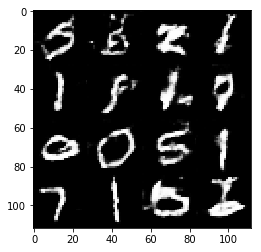

Epoch 2/2... Discriminator Loss: 0.5704... Generator Loss: 3.3566
Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 3.7598
Epoch 2/2... Discriminator Loss: 0.5852... Generator Loss: 3.3931
Epoch 2/2... Discriminator Loss: 0.5284... Generator Loss: 3.9786
Epoch 2/2... Discriminator Loss: 0.7110... Generator Loss: 4.7084
Epoch 2/2... Discriminator Loss: 0.5527... Generator Loss: 3.0762
Epoch 2/2... Discriminator Loss: 0.5284... Generator Loss: 3.7675
Epoch 2/2... Discriminator Loss: 0.6799... Generator Loss: 4.4216
Epoch 2/2... Discriminator Loss: 0.5343... Generator Loss: 4.2172
Epoch 2/2... Discriminator Loss: 0.5431... Generator Loss: 3.1657


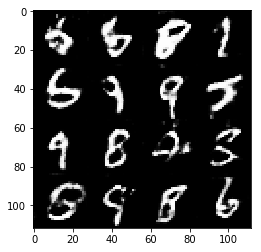

Epoch 2/2... Discriminator Loss: 0.6381... Generator Loss: 2.7691
Epoch 2/2... Discriminator Loss: 0.5645... Generator Loss: 4.1861
Epoch 2/2... Discriminator Loss: 0.5868... Generator Loss: 3.9760
Epoch 2/2... Discriminator Loss: 0.5265... Generator Loss: 4.2698
Epoch 2/2... Discriminator Loss: 0.5377... Generator Loss: 3.4516
Epoch 2/2... Discriminator Loss: 0.5266... Generator Loss: 3.8876
Epoch 2/2... Discriminator Loss: 0.5462... Generator Loss: 3.4191
Epoch 2/2... Discriminator Loss: 0.5266... Generator Loss: 4.0836
Epoch 2/2... Discriminator Loss: 0.5592... Generator Loss: 4.0541
Epoch 2/2... Discriminator Loss: 0.5639... Generator Loss: 3.6232


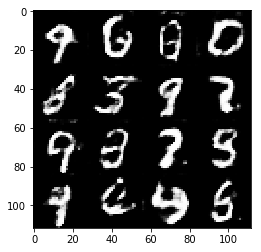

Epoch 2/2... Discriminator Loss: 0.6503... Generator Loss: 3.0396
Epoch 2/2... Discriminator Loss: 0.5338... Generator Loss: 3.5542
Epoch 2/2... Discriminator Loss: 0.6292... Generator Loss: 3.4463
Epoch 2/2... Discriminator Loss: 0.5274... Generator Loss: 4.1263
Epoch 2/2... Discriminator Loss: 0.5197... Generator Loss: 3.8110
Epoch 2/2... Discriminator Loss: 0.5401... Generator Loss: 3.2887
Epoch 2/2... Discriminator Loss: 0.5467... Generator Loss: 4.0264
Epoch 2/2... Discriminator Loss: 0.5314... Generator Loss: 4.2457
Epoch 2/2... Discriminator Loss: 0.5544... Generator Loss: 3.4973
Epoch 2/2... Discriminator Loss: 0.5141... Generator Loss: 4.3281


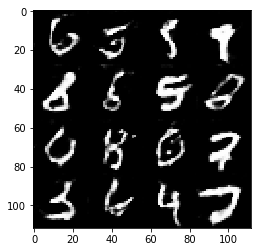

Epoch 2/2... Discriminator Loss: 0.5371... Generator Loss: 3.8147
Epoch 2/2... Discriminator Loss: 0.5263... Generator Loss: 3.6016
Epoch 2/2... Discriminator Loss: 0.5306... Generator Loss: 3.8755
Epoch 2/2... Discriminator Loss: 0.5347... Generator Loss: 3.4929
Epoch 2/2... Discriminator Loss: 0.5464... Generator Loss: 3.7355
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 4.5024
Epoch 2/2... Discriminator Loss: 0.5488... Generator Loss: 4.2725
Epoch 2/2... Discriminator Loss: 0.5216... Generator Loss: 3.8294
Epoch 2/2... Discriminator Loss: 0.5474... Generator Loss: 2.8936
Epoch 2/2... Discriminator Loss: 0.5376... Generator Loss: 3.6832


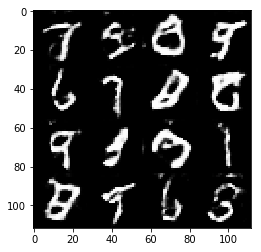

Epoch 2/2... Discriminator Loss: 0.5245... Generator Loss: 3.8949
Epoch 2/2... Discriminator Loss: 0.5398... Generator Loss: 3.3528
Epoch 2/2... Discriminator Loss: 0.5640... Generator Loss: 3.2023
Epoch 2/2... Discriminator Loss: 0.5317... Generator Loss: 3.3514
Epoch 2/2... Discriminator Loss: 0.5259... Generator Loss: 3.1743
Epoch 2/2... Discriminator Loss: 0.6033... Generator Loss: 3.1081
Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 3.5357
Epoch 2/2... Discriminator Loss: 0.5306... Generator Loss: 3.3879
Epoch 2/2... Discriminator Loss: 0.5564... Generator Loss: 2.9030
Epoch 2/2... Discriminator Loss: 0.5753... Generator Loss: 3.2622


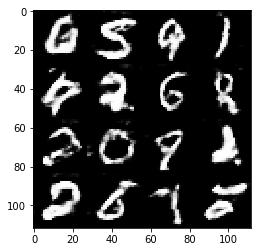

Epoch 2/2... Discriminator Loss: 0.5387... Generator Loss: 3.8348
Epoch 2/2... Discriminator Loss: 0.5647... Generator Loss: 4.3817
Epoch 2/2... Discriminator Loss: 0.5773... Generator Loss: 4.2092
Epoch 2/2... Discriminator Loss: 0.5289... Generator Loss: 3.8052
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 4.4712
Epoch 2/2... Discriminator Loss: 0.5732... Generator Loss: 4.4543
Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 3.8708
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 3.2281
Epoch 2/2... Discriminator Loss: 0.5503... Generator Loss: 3.4991
Epoch 2/2... Discriminator Loss: 0.5353... Generator Loss: 3.4191


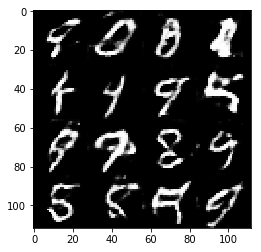

Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 3.5402
Epoch 2/2... Discriminator Loss: 0.5544... Generator Loss: 4.3252
Epoch 2/2... Discriminator Loss: 0.5393... Generator Loss: 3.4382
Epoch 2/2... Discriminator Loss: 0.5748... Generator Loss: 4.1856
Epoch 2/2... Discriminator Loss: 0.5482... Generator Loss: 3.5835
Epoch 2/2... Discriminator Loss: 0.5286... Generator Loss: 3.6895
Epoch 2/2... Discriminator Loss: 0.5446... Generator Loss: 3.4800
Epoch 2/2... Discriminator Loss: 0.5396... Generator Loss: 3.5834
Epoch 2/2... Discriminator Loss: 0.5194... Generator Loss: 3.9074
Epoch 2/2... Discriminator Loss: 0.5341... Generator Loss: 4.0863


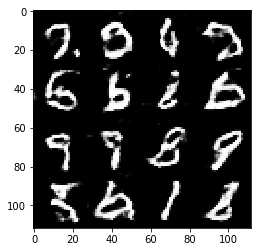

Epoch 2/2... Discriminator Loss: 0.6076... Generator Loss: 2.6788
Epoch 2/2... Discriminator Loss: 0.5383... Generator Loss: 3.3389
Epoch 2/2... Discriminator Loss: 0.5229... Generator Loss: 3.8542
Epoch 2/2... Discriminator Loss: 0.5382... Generator Loss: 3.8687
Epoch 2/2... Discriminator Loss: 0.5320... Generator Loss: 3.4473
Epoch 2/2... Discriminator Loss: 0.5489... Generator Loss: 3.3112
Epoch 2/2... Discriminator Loss: 0.5278... Generator Loss: 3.6641
Epoch 2/2... Discriminator Loss: 0.5229... Generator Loss: 3.9003
Epoch 2/2... Discriminator Loss: 0.6114... Generator Loss: 2.9880
Epoch 2/2... Discriminator Loss: 0.5293... Generator Loss: 3.6647


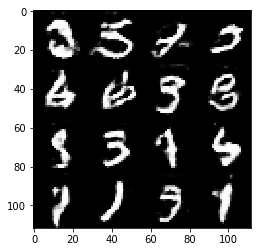

Epoch 2/2... Discriminator Loss: 0.5243... Generator Loss: 4.0465
Epoch 2/2... Discriminator Loss: 0.5650... Generator Loss: 3.3044
Epoch 2/2... Discriminator Loss: 0.5518... Generator Loss: 4.3383
Epoch 2/2... Discriminator Loss: 0.5464... Generator Loss: 3.6325
Epoch 2/2... Discriminator Loss: 0.5330... Generator Loss: 3.6255
Epoch 2/2... Discriminator Loss: 0.5203... Generator Loss: 3.7929
Epoch 2/2... Discriminator Loss: 0.5271... Generator Loss: 4.0197
Epoch 2/2... Discriminator Loss: 0.6007... Generator Loss: 4.3341
Epoch 2/2... Discriminator Loss: 0.5635... Generator Loss: 4.1268
Epoch 2/2... Discriminator Loss: 0.5170... Generator Loss: 3.7106


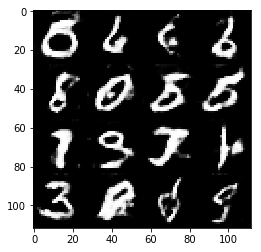

Epoch 2/2... Discriminator Loss: 0.5282... Generator Loss: 4.5757
Epoch 2/2... Discriminator Loss: 0.5298... Generator Loss: 3.7316
Epoch 2/2... Discriminator Loss: 0.5650... Generator Loss: 3.1558
Epoch 2/2... Discriminator Loss: 0.5288... Generator Loss: 3.6889
Epoch 2/2... Discriminator Loss: 0.5280... Generator Loss: 3.5975
Epoch 2/2... Discriminator Loss: 0.5458... Generator Loss: 3.4674
Epoch 2/2... Discriminator Loss: 0.5972... Generator Loss: 4.0158
Epoch 2/2... Discriminator Loss: 0.5462... Generator Loss: 3.7369
Epoch 2/2... Discriminator Loss: 0.5802... Generator Loss: 3.3328
Epoch 2/2... Discriminator Loss: 0.5406... Generator Loss: 3.4858


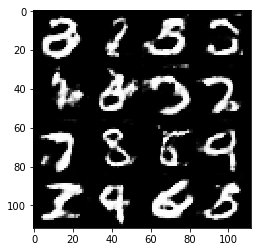

Epoch 2/2... Discriminator Loss: 0.5427... Generator Loss: 3.6790
Epoch 2/2... Discriminator Loss: 0.5535... Generator Loss: 4.5321
Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 5.5545
Epoch 2/2... Discriminator Loss: 0.5334... Generator Loss: 3.6971
Epoch 2/2... Discriminator Loss: 0.5676... Generator Loss: 3.4714
Epoch 2/2... Discriminator Loss: 0.5519... Generator Loss: 3.5343
Epoch 2/2... Discriminator Loss: 0.6854... Generator Loss: 4.5448
Epoch 2/2... Discriminator Loss: 0.5345... Generator Loss: 3.6483
Epoch 2/2... Discriminator Loss: 0.5381... Generator Loss: 3.3731
Epoch 2/2... Discriminator Loss: 0.5254... Generator Loss: 3.7720


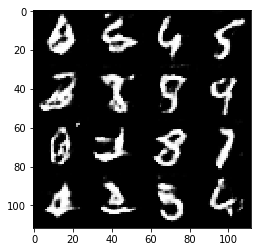

Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 4.8492
Epoch 2/2... Discriminator Loss: 0.5503... Generator Loss: 3.3083
Epoch 2/2... Discriminator Loss: 0.6558... Generator Loss: 4.5892
Epoch 2/2... Discriminator Loss: 0.5512... Generator Loss: 3.1025
Epoch 2/2... Discriminator Loss: 0.5271... Generator Loss: 4.1315
Epoch 2/2... Discriminator Loss: 0.5317... Generator Loss: 3.2728
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 3.2952
Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 4.0006
Epoch 2/2... Discriminator Loss: 0.5277... Generator Loss: 3.8096
Epoch 2/2... Discriminator Loss: 0.5294... Generator Loss: 3.2185


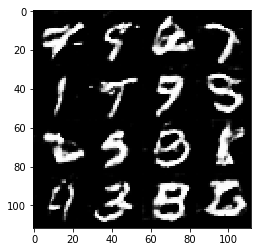

Epoch 2/2... Discriminator Loss: 0.5895... Generator Loss: 4.8840


In [35]:
batch_size = 16
z_dim = 100
learning_rate = 0.0004
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 3.6278
Epoch 1/1... Discriminator Loss: 0.5792... Generator Loss: 4.1814
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.7328
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 3.7084
Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 3.9821
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 3.6824
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 4.5574
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 3.9070
Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 4.2722


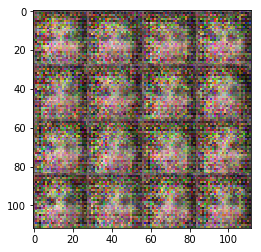

Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 4.8683
Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 3.9373
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 4.0915
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 4.4008
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 2.5403
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 2.4821
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 3.4557
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 2.9693
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 3.9567
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 5.2019


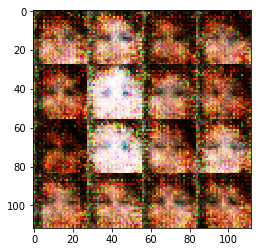

Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 5.0973
Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 3.6518
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 3.4016
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 2.6993
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 3.4921
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 3.6413
Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 3.3208
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 4.4010
Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 3.3151
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 5.2552


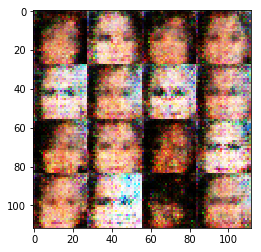

Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 4.3267
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.7930
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 3.2624
Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 3.5025
Epoch 1/1... Discriminator Loss: 0.5164... Generator Loss: 3.4097
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 3.2213
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 2.5757
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.9461
Epoch 1/1... Discriminator Loss: 0.5704... Generator Loss: 4.0829
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 3.3833


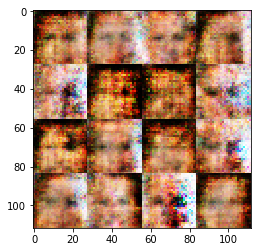

Epoch 1/1... Discriminator Loss: 0.5695... Generator Loss: 4.0921
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 6.1446
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 2.4762
Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 3.5573
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 3.6768
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 3.7861
Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 2.7150
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 5.9828
Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 2.6733
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 2.7176


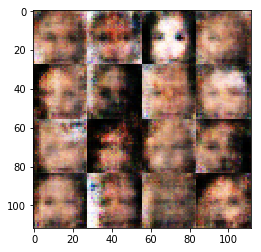

Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 2.3153
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 2.7892
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.8531
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 2.9484
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 4.9164
Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 2.7042
Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 2.4942
Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 3.0852
Epoch 1/1... Discriminator Loss: 0.5394... Generator Loss: 3.0268
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 2.4802


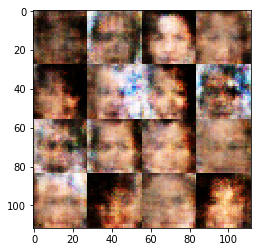

Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 2.5462
Epoch 1/1... Discriminator Loss: 0.5385... Generator Loss: 3.5051
Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 2.4159
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 2.5071
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 2.5130
Epoch 1/1... Discriminator Loss: 0.5389... Generator Loss: 3.0670
Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 3.2755
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 2.7361
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 3.8917
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 2.7423


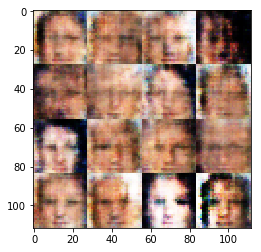

Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.8092
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 2.8177
Epoch 1/1... Discriminator Loss: 0.5333... Generator Loss: 3.1625
Epoch 1/1... Discriminator Loss: 0.5385... Generator Loss: 3.9560
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 2.9408
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 2.4451
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 3.6566
Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 3.4950
Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 2.9648
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 2.4651


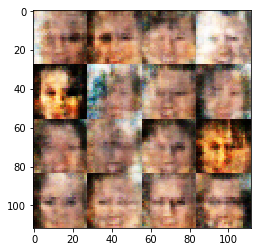

Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 2.3827
Epoch 1/1... Discriminator Loss: 0.5091... Generator Loss: 3.0505
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 2.9456
Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 2.3701
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 2.7550
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.2721
Epoch 1/1... Discriminator Loss: 0.5700... Generator Loss: 2.4613
Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 2.5288
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.6119
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 4.0412


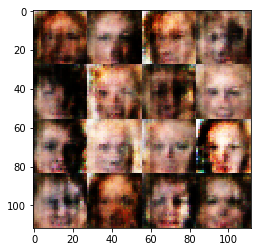

Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 2.6895
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 2.8668
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 2.3776
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 2.6848
Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 2.1999
Epoch 1/1... Discriminator Loss: 0.5590... Generator Loss: 2.5374
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 2.9384
Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 2.5073
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 2.9616
Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 2.8082


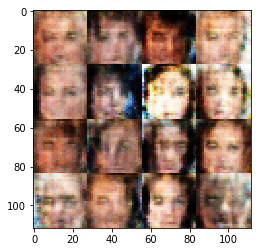

Epoch 1/1... Discriminator Loss: 0.5523... Generator Loss: 2.3089
Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 3.1570
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 2.8794
Epoch 1/1... Discriminator Loss: 0.5372... Generator Loss: 2.6435
Epoch 1/1... Discriminator Loss: 0.5341... Generator Loss: 3.4261
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 3.0314
Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 2.5149
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 2.5979
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 3.0004
Epoch 1/1... Discriminator Loss: 0.5372... Generator Loss: 2.6700


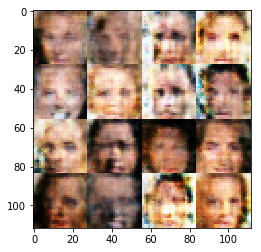

Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 3.1697
Epoch 1/1... Discriminator Loss: 0.5543... Generator Loss: 3.5294
Epoch 1/1... Discriminator Loss: 0.5249... Generator Loss: 2.8817
Epoch 1/1... Discriminator Loss: 0.5318... Generator Loss: 2.7344
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 2.5528
Epoch 1/1... Discriminator Loss: 0.5609... Generator Loss: 3.0377
Epoch 1/1... Discriminator Loss: 0.5506... Generator Loss: 2.7435
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.4670
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 3.3815
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 3.1941


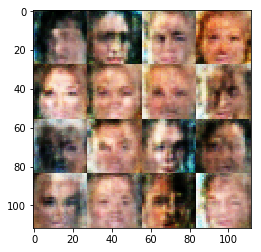

Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 3.9752
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 2.3753
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 2.6953
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 3.1382
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 2.6256
Epoch 1/1... Discriminator Loss: 0.5319... Generator Loss: 3.0225
Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 3.3074
Epoch 1/1... Discriminator Loss: 0.5164... Generator Loss: 2.9127
Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 3.9604
Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 3.7568


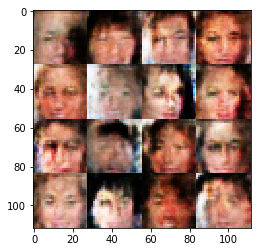

Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 2.9249
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 2.8589
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 2.9946
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 2.6349
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.6657
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 2.5526
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 2.6193
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 3.0231
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 2.6496
Epoch 1/1... Discriminator Loss: 0.5278... Generator Loss: 3.0281


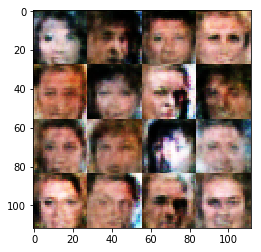

Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 2.3401
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 3.0503
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 2.9119
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 2.8443
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.3879
Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 2.9292
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 2.3284
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 2.6061
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 2.9165
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.4106


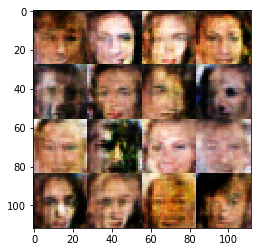

Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 3.3129
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 2.7112
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 2.4154
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 2.7960
Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 3.3310
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 3.6785
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 2.7537
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 2.4373
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 3.2672
Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 2.2597


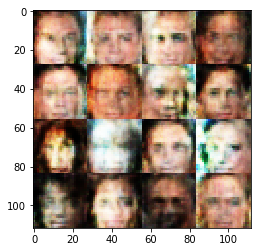

Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 2.9000
Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 2.7763
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 3.0011
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 3.9481
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 2.6342
Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 2.6774
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 2.6212
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 2.4095
Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 2.7006
Epoch 1/1... Discriminator Loss: 0.5110... Generator Loss: 2.9147


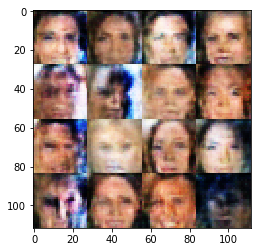

Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 3.0980
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 3.1525
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 2.5418
Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 2.8121
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 2.8329
Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 2.8982
Epoch 1/1... Discriminator Loss: 0.5234... Generator Loss: 2.6995
Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 3.0265
Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 2.4833
Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 2.8269


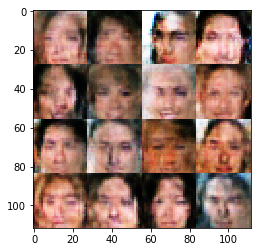

Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 2.9408
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 3.6686
Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 2.2969
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 2.7046
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 2.6365
Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 2.4596
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 2.3046
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 3.0717
Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 2.8644
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 2.4413


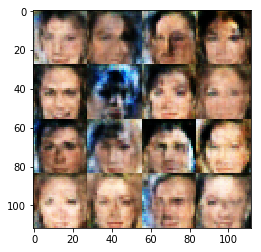

Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 2.9519
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 3.2055
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 2.9413
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 2.6975
Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 2.4614
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 2.6742
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 2.9252
Epoch 1/1... Discriminator Loss: 0.5372... Generator Loss: 2.7151
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 2.6660
Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 2.3047


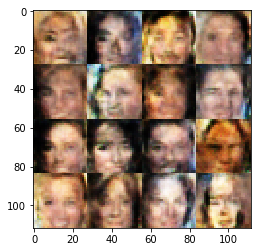

Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 2.6935
Epoch 1/1... Discriminator Loss: 0.5232... Generator Loss: 2.7346
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 2.5350
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 3.0509
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 2.5744
Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 3.0555
Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 2.7042
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.7085
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 2.6872
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 2.8099


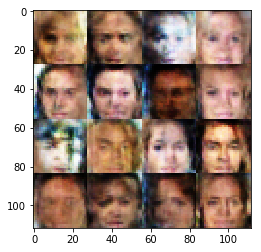

Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 2.6804
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 2.9482
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 2.7514
Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 3.1535
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 4.4061
Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 2.7257
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 4.0506
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 2.7039
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 2.9873
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 3.4563


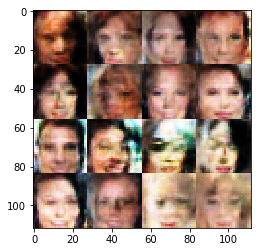

Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 4.2029
Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 3.4343
Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 2.8126
Epoch 1/1... Discriminator Loss: 0.5785... Generator Loss: 2.3194
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.7446
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 2.4297
Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 2.5075
Epoch 1/1... Discriminator Loss: 0.5284... Generator Loss: 2.9991
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 3.0243
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 3.7493


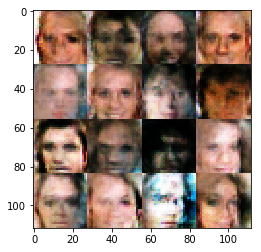

Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 2.6053
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 2.7202
Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 3.3642
Epoch 1/1... Discriminator Loss: 0.5213... Generator Loss: 2.9526
Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 4.0089
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 2.4232
Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 3.7049
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 2.4750
Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 2.4366
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 2.7148


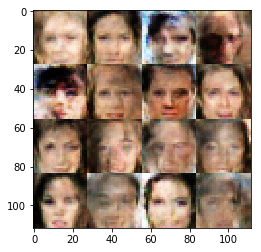

Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 3.3580
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 2.7750
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 3.0239
Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 2.9983
Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 2.1979
Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 3.5439
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 2.4565
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 3.9252
Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 2.9794
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 3.7005


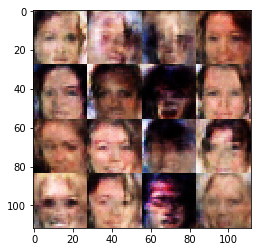

Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 2.8555
Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 4.0141
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 2.5397
Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 2.3820
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 2.4763
Epoch 1/1... Discriminator Loss: 0.5457... Generator Loss: 3.0059
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 2.8538
Epoch 1/1... Discriminator Loss: 0.5268... Generator Loss: 3.0277
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 2.3322
Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 2.6027


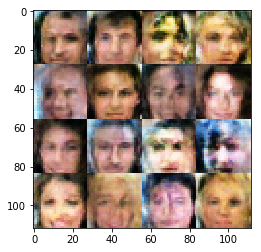

Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 3.7308
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 3.5081
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 3.0315
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 2.6459
Epoch 1/1... Discriminator Loss: 0.5333... Generator Loss: 2.6112
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 3.5814
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 2.8267
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 2.8945
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 2.9332
Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 2.5254


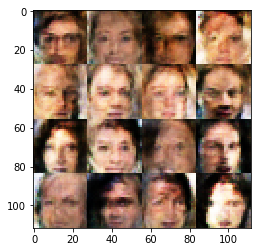

Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 3.2102
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 3.3530
Epoch 1/1... Discriminator Loss: 0.5278... Generator Loss: 2.8920
Epoch 1/1... Discriminator Loss: 0.5119... Generator Loss: 3.0916
Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 3.5561
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 2.5829
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 2.6112
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 2.4060
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 3.0815
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 2.4841


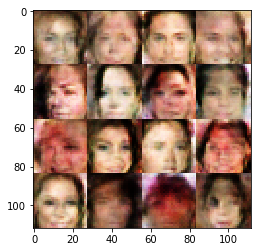

Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 2.8222
Epoch 1/1... Discriminator Loss: 0.5967... Generator Loss: 4.0164
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 2.9065
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 2.9056
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 3.1590
Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 3.5231
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 2.8916
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.8831
Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 3.1375
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 4.2143


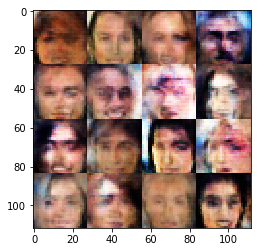

Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 3.2658
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 3.4700
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 2.7960
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 2.9836
Epoch 1/1... Discriminator Loss: 0.5326... Generator Loss: 2.4499
Epoch 1/1... Discriminator Loss: 0.5278... Generator Loss: 2.6359
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 2.5983
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 3.3772
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 3.4011
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 3.5366


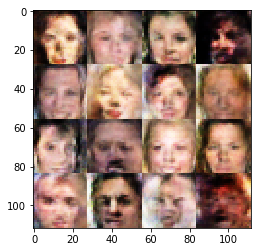

Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 3.4262
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 2.4393
Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 3.5780
Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 2.8582
Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 2.6420
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 2.8316
Epoch 1/1... Discriminator Loss: 0.5205... Generator Loss: 2.6059
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 2.5271
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 2.6026
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 2.2249


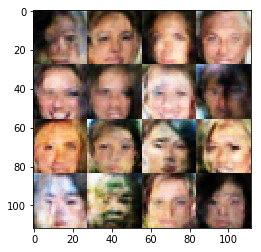

Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 2.4734
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 3.0735
Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 2.8767
Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 2.9390
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 2.6636
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 2.3237
Epoch 1/1... Discriminator Loss: 0.5212... Generator Loss: 3.0495
Epoch 1/1... Discriminator Loss: 0.5192... Generator Loss: 2.7774
Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 3.3458
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 3.2056


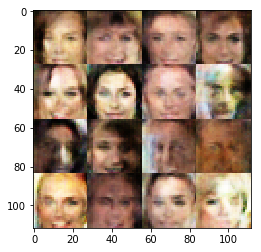

Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 3.5593
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 3.4860
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 2.4943
Epoch 1/1... Discriminator Loss: 0.5245... Generator Loss: 2.3649
Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 2.4804
Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 3.0747
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 3.1859
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 2.7943
Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 2.4553
Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 2.8514


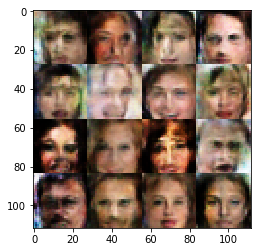

Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 4.2021
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 2.3867
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 4.1727
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 2.8730
Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 2.7720
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 3.3598
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 2.1224
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 2.8300
Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 3.1942
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 2.7917


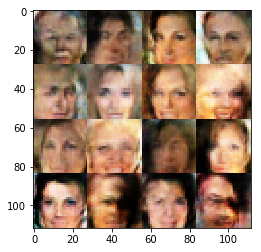

Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 2.7113
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 2.8040
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 2.4070
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 3.6257
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 3.0708
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 2.8393
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 2.5167
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 2.4267
Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 2.6303
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.4936


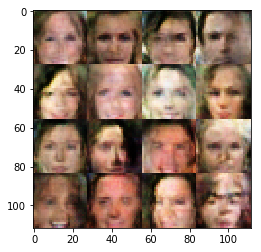

Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 3.0915
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.9837
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.6314
Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 3.8401
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 2.6997
Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 2.3521
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 2.9938
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 2.8912
Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 2.4092
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 3.2321


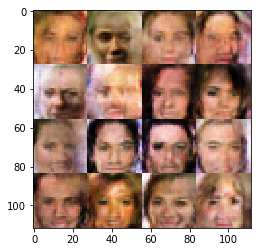

Epoch 1/1... Discriminator Loss: 0.5213... Generator Loss: 3.3433
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 3.1294
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.5371
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.8090
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 3.2018
Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 3.4636
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 3.4661
Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 2.9461
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 3.4603
Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 3.4442


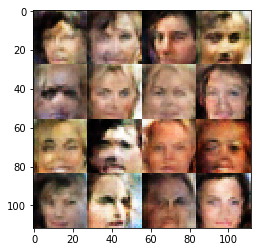

Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 3.1986
Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 2.8957
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.6682
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 3.0024
Epoch 1/1... Discriminator Loss: 0.5189... Generator Loss: 3.1150
Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 2.4305
Epoch 1/1... Discriminator Loss: 0.5268... Generator Loss: 2.9111
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 3.3502
Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 3.7451
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 3.2946


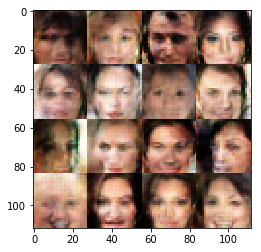

Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 3.1109
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 2.5261
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 2.5427
Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 2.9365
Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 3.5890
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 2.3805
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 3.3450
Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 2.1867
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 3.1037
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 3.0800


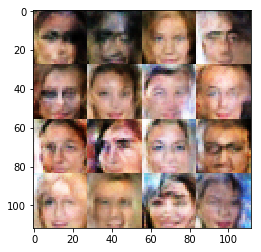

Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 2.1865
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 2.8728
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 2.3802
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 3.6172
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 2.6825
Epoch 1/1... Discriminator Loss: 0.5390... Generator Loss: 3.2315
Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 2.9003
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 3.9632
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.4667
Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 2.6650


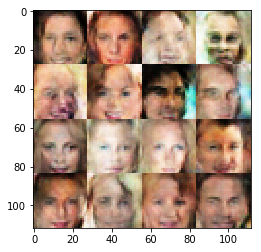

Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 2.7838
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 2.4990
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 2.7683
Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 2.9397
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 3.0248
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 3.3107
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 4.0610
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 2.8130
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 3.0282
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 2.8799


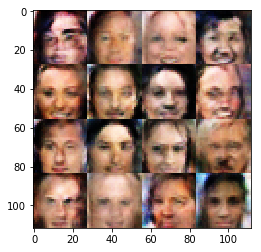

Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 2.8383
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 2.7873
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 2.8587
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 3.1199
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 3.4244
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 2.8208
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 3.1339
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 2.9071
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 3.2940
Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 2.8443


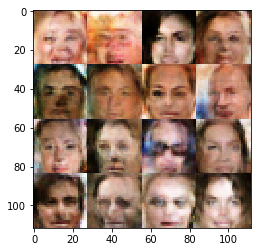

Epoch 1/1... Discriminator Loss: 0.5211... Generator Loss: 2.6875
Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 2.4922
Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 2.6599
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 2.2285
Epoch 1/1... Discriminator Loss: 0.5131... Generator Loss: 2.8289
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 3.1718
Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 3.4714
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 3.0285
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 2.9085
Epoch 1/1... Discriminator Loss: 0.5574... Generator Loss: 2.3359


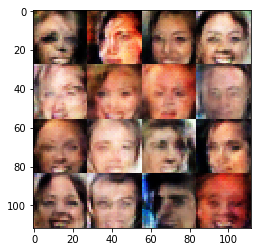

Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 2.6934
Epoch 1/1... Discriminator Loss: 0.5695... Generator Loss: 2.5430
Epoch 1/1... Discriminator Loss: 0.5109... Generator Loss: 2.6774
Epoch 1/1... Discriminator Loss: 0.5596... Generator Loss: 2.4444
Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 3.0643
Epoch 1/1... Discriminator Loss: 0.5502... Generator Loss: 2.5204
Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 3.5304
Epoch 1/1... Discriminator Loss: 0.5211... Generator Loss: 2.7004
Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 2.9676
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 3.3326


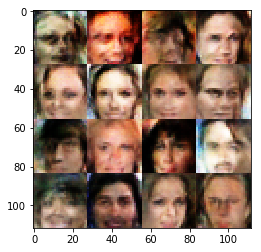

Epoch 1/1... Discriminator Loss: 0.5294... Generator Loss: 3.6208
Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 2.7592
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 3.4710
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 3.2387
Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 3.2968
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 2.5039
Epoch 1/1... Discriminator Loss: 0.5265... Generator Loss: 3.5347
Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 3.9427
Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 3.1274
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 2.6320


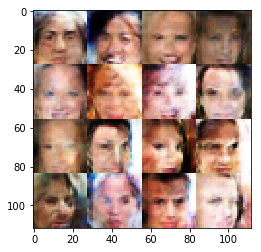

Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 3.9413
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 2.3476
Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 3.0846
Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 3.2954
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 2.8327
Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 3.2043
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 4.1799
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 2.6123
Epoch 1/1... Discriminator Loss: 0.4970... Generator Loss: 3.2666
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 3.0513


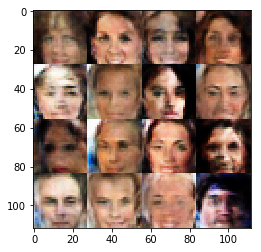

Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 3.8164
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 2.5173
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 3.4880
Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 2.9348
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.6530
Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 2.8679
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 2.8898
Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 2.8476
Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 3.8609
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 2.6709


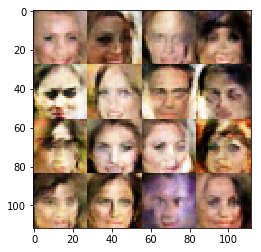

Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 2.3019
Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 2.5885
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 3.5043
Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 2.8383
Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 2.4005
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 3.3145
Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 2.2462
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 3.5563
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 2.5856
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 2.7586


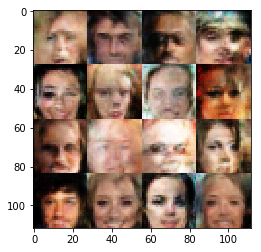

Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 2.9284
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 3.5574
Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 3.1901
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 3.0522
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 2.4400
Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 3.3783
Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.8966
Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 3.5643
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 3.4905
Epoch 1/1... Discriminator Loss: 0.5183... Generator Loss: 2.5688


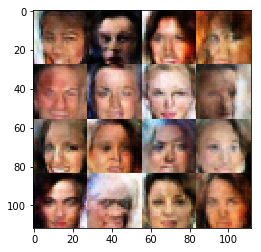

Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 3.1921
Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 2.5006
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 3.9059
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.9714
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 2.9429
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 2.7550
Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 2.9932
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 2.4897
Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 2.8867
Epoch 1/1... Discriminator Loss: 0.4970... Generator Loss: 3.3998


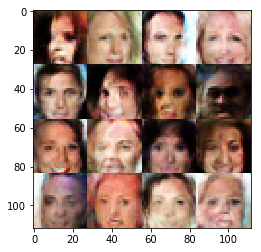

Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 2.3804
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 2.8150
Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 3.6551
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 2.8015
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 3.0409
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 2.6819
Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 2.7677
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 3.2489
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.7424
Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 2.7377


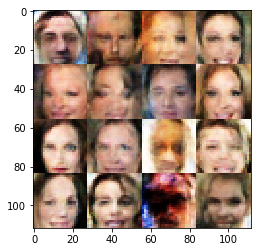

Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 2.6686
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 3.0600
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 2.8874
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 3.1615
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 2.8083
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 2.9984
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 3.3453
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 2.5261
Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 2.8778
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.6984


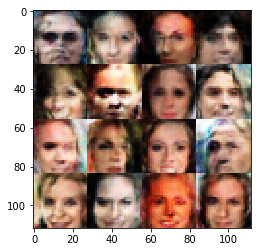

Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 3.0374
Epoch 1/1... Discriminator Loss: 0.5326... Generator Loss: 2.7085
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 2.6420
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 3.1596
Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 2.3773
Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 3.4808
Epoch 1/1... Discriminator Loss: 0.5458... Generator Loss: 2.6516
Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 3.1214
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 3.8308
Epoch 1/1... Discriminator Loss: 0.5006... Generator Loss: 2.9995


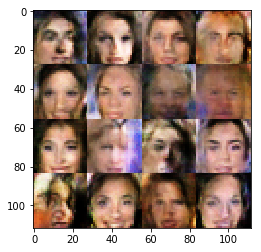

Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 3.1017
Epoch 1/1... Discriminator Loss: 0.4999... Generator Loss: 2.9469
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 2.8909
Epoch 1/1... Discriminator Loss: 0.4949... Generator Loss: 2.8500
Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 3.7037
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 3.3077
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 3.1937
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 2.7623
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 3.6312
Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 2.5029


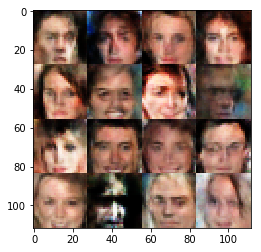

Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 2.6835
Epoch 1/1... Discriminator Loss: 0.5289... Generator Loss: 2.6046
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 2.8960
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 2.8553
Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 3.1883
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 3.4740
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 2.9902
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 3.0837
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 2.7676
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 3.3918


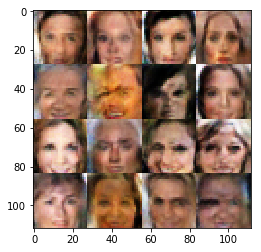

Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 3.6476
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 2.4198
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 3.0009
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 2.9393
Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 2.4156
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 2.4296
Epoch 1/1... Discriminator Loss: 0.5192... Generator Loss: 3.3717
Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 3.0588
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 3.2570
Epoch 1/1... Discriminator Loss: 0.4822... Generator Loss: 3.3840


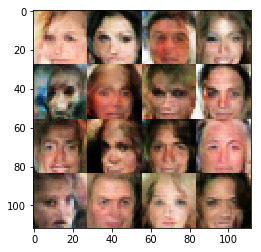

Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.7695
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 3.6486
Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 3.3025
Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 2.6472
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 2.4742
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 2.9980
Epoch 1/1... Discriminator Loss: 0.5040... Generator Loss: 2.8802
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 3.3648
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 3.2895
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 2.8537


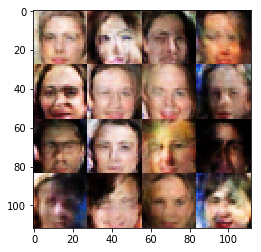

Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 4.5390
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 3.1765
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 3.6982
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 3.0793
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 2.6200
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 3.7258
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 3.1009
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 3.7802
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 3.1585
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 4.2816


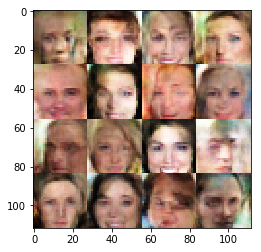

Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 2.8443
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 2.9100
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 2.7395
Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 2.5924
Epoch 1/1... Discriminator Loss: 0.5249... Generator Loss: 2.7729
Epoch 1/1... Discriminator Loss: 0.5287... Generator Loss: 2.9095
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 3.5684
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 3.2035
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 3.2065
Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 4.0041


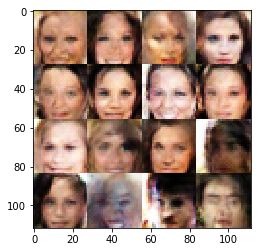

Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 3.1113
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 3.1700
Epoch 1/1... Discriminator Loss: 0.5109... Generator Loss: 3.1822
Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 3.3737
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 3.0481
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 2.8897
Epoch 1/1... Discriminator Loss: 0.5091... Generator Loss: 3.0992
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 3.4068
Epoch 1/1... Discriminator Loss: 0.5047... Generator Loss: 3.1291
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 3.3539


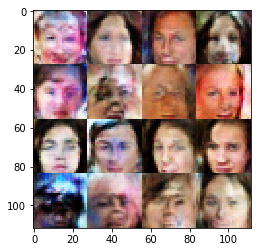

Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 2.9506
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.7981
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 2.5163
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 2.8997
Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 2.6937
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 3.4654
Epoch 1/1... Discriminator Loss: 0.4915... Generator Loss: 3.3218
Epoch 1/1... Discriminator Loss: 0.5205... Generator Loss: 2.8887
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 3.7646
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 3.5437


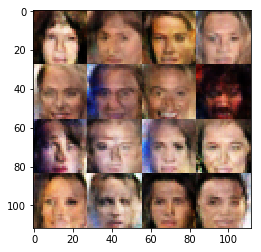

Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 3.3954
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 4.1579
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 3.2595
Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.8589
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 2.8839
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 3.2147
Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 4.7211
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 3.1064
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 3.1981
Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 2.6608


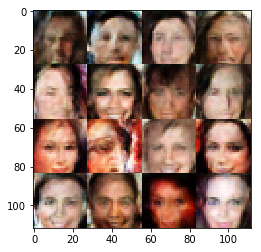

Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 3.4886
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 3.3064
Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 3.0360
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 2.3008
Epoch 1/1... Discriminator Loss: 0.5159... Generator Loss: 3.0801
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.7440
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 4.7252
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 2.9948
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 2.7212
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 3.6839


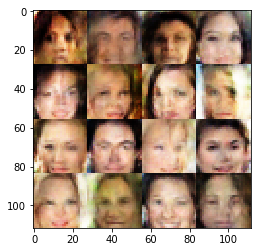

Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 2.5360
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 2.5376
Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 3.4955
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 3.5148
Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 3.3286
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 3.1327
Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 2.6040
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 2.5356
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 2.7682
Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 3.2478


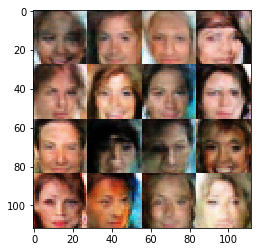

Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 2.7213
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 3.0435
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 3.0932
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 3.2058
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 3.3922
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 2.9451
Epoch 1/1... Discriminator Loss: 0.4883... Generator Loss: 3.5271
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 3.5886
Epoch 1/1... Discriminator Loss: 0.5047... Generator Loss: 3.0818
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 2.3220


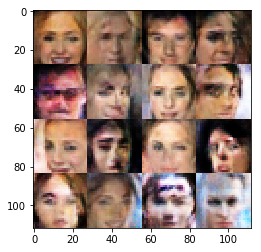

Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 3.7958
Epoch 1/1... Discriminator Loss: 0.5598... Generator Loss: 3.5734
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 2.7294
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 3.3246
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 2.9874
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 3.0934
Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 3.2382
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 3.1741
Epoch 1/1... Discriminator Loss: 0.4898... Generator Loss: 3.4049
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 2.9614


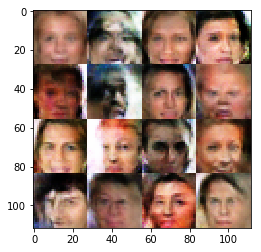

Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 3.0067
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 3.1150
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 3.6867
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 2.7134
Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 3.0688
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 3.5642
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 3.0871
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 3.3387
Epoch 1/1... Discriminator Loss: 0.5533... Generator Loss: 3.9788
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 4.1673


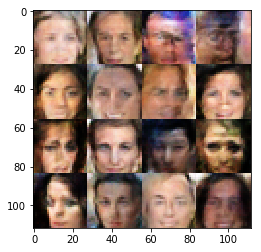

Epoch 1/1... Discriminator Loss: 0.4888... Generator Loss: 3.3771
Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 3.4783
Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 3.3841
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 3.2654
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 3.3435
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 3.3275
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 2.9248
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 2.9439
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 3.3145
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 3.1207


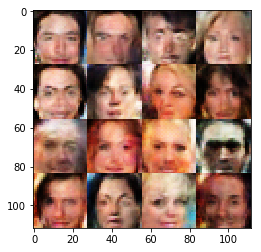

Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 2.8769
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 3.8374
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 4.1245
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 3.1110
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 3.0887
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 2.9097
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 3.2162
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 3.3560
Epoch 1/1... Discriminator Loss: 0.5159... Generator Loss: 2.9240
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 2.0735


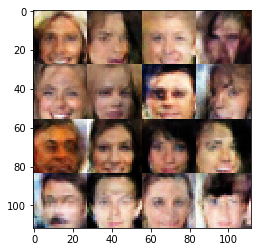

Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 3.2842
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 2.8316
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 3.4066
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 3.6309
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 2.7390
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 2.5597
Epoch 1/1... Discriminator Loss: 0.5159... Generator Loss: 2.8749
Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 3.5184
Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 2.9677
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 2.9189


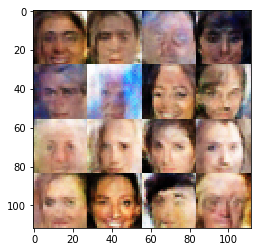

Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 3.5921
Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 3.2938
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 3.2386
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 3.1276
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 3.2341
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 3.0184
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 2.8586
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 3.8741
Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 3.3820
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 2.9285


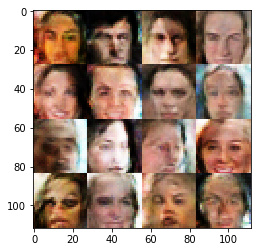

Epoch 1/1... Discriminator Loss: 0.4983... Generator Loss: 3.3038
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.9025
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 3.3584
Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 3.2579
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 3.1017
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 3.1470
Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 2.7809
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 3.2816
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 3.1761
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 3.0438


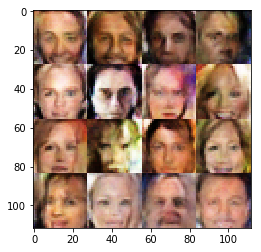

Epoch 1/1... Discriminator Loss: 0.4984... Generator Loss: 2.8837
Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 2.3190
Epoch 1/1... Discriminator Loss: 0.5109... Generator Loss: 3.1373
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 3.1858
Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 2.9039
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 3.7662
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 3.1501
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 3.3163
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 4.2582
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 3.5731


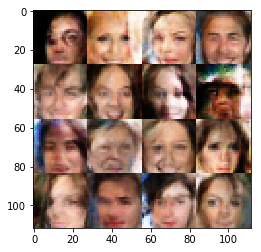

Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 3.7155
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 3.2977
Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 2.7029
Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 3.5860
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 2.9898
Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 3.2066
Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 2.7839
Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 2.8699
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 2.8884
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 2.8228


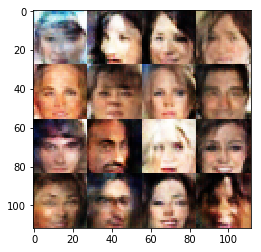

Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 4.3082
Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 2.9270
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 2.9229
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 2.6453
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 3.4744
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 2.8900
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 2.8134
Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 3.2356
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 3.5837
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 2.8084


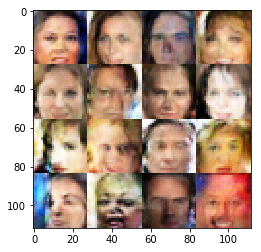

Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 3.5138
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 3.1086
Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 3.2352
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 3.0307
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 3.1677
Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 3.2466
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 3.8999
Epoch 1/1... Discriminator Loss: 0.5003... Generator Loss: 3.1963
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 3.2018
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 3.1839


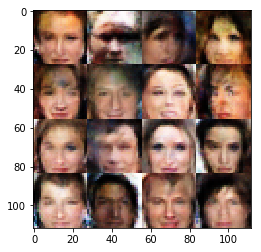

Epoch 1/1... Discriminator Loss: 0.5244... Generator Loss: 3.8953
Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 3.1478
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 3.1044
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 2.9295
Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 3.2394
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 3.0334
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 3.3501
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 2.9332
Epoch 1/1... Discriminator Loss: 0.4898... Generator Loss: 3.2271
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 3.3777


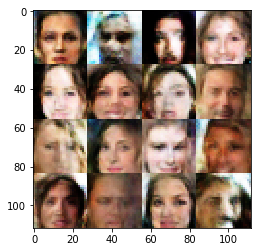

Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 3.7658
Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 3.4138
Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 2.9981
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 4.0567
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 2.8793
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 2.9848
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 3.4984
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 2.2610
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 2.9693
Epoch 1/1... Discriminator Loss: 0.5488... Generator Loss: 2.8566


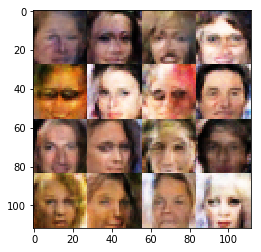

Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 3.1977
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 2.9500
Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 3.2622
Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 3.2034
Epoch 1/1... Discriminator Loss: 0.5338... Generator Loss: 3.6480
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 3.4552
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 3.0330
Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 2.8264
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 3.6050
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 2.8172


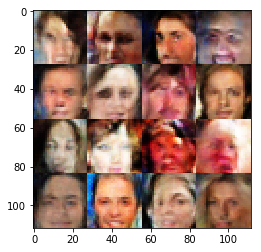

Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 3.3187
Epoch 1/1... Discriminator Loss: 0.5458... Generator Loss: 2.6352
Epoch 1/1... Discriminator Loss: 0.4913... Generator Loss: 3.5718
Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 3.6147
Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 4.1726
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 2.9107
Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 3.0286
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 3.6874
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 2.7893
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 3.5820


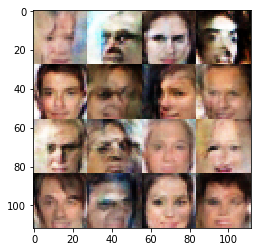

Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 3.1395
Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 4.2857
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 3.6214
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 3.7193
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 2.5424
Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 3.0196
Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 3.3400
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 3.0976
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 3.3649
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 3.4246


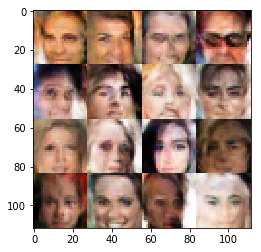

Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 3.4037
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 3.9317
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 2.7544
Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 4.8061
Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 3.3077
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 2.8553
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 2.6790
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 2.5480
Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 2.8689
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 2.9822


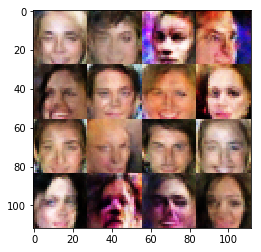

Epoch 1/1... Discriminator Loss: 0.5078... Generator Loss: 3.1211
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 3.1837
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 3.0521
Epoch 1/1... Discriminator Loss: 0.4867... Generator Loss: 3.3253
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 2.7853
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 3.5235
Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 3.4137
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 3.8217
Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 3.6992
Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 3.1533


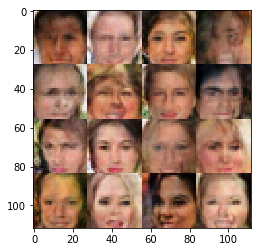

Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 3.1080
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 3.5700
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 3.7187
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 4.0671
Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 3.3326
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 3.1466
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 3.9787
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 3.6388
Epoch 1/1... Discriminator Loss: 0.5301... Generator Loss: 3.8662
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 2.5855


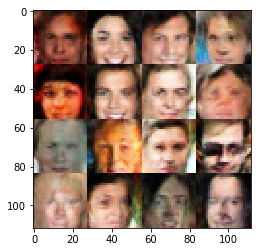

Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 2.9427
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 3.3943
Epoch 1/1... Discriminator Loss: 0.4855... Generator Loss: 3.5812
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 3.1947
Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 3.5414
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 3.7196
Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 3.1360
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 3.3146
Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 3.2054
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 2.8533


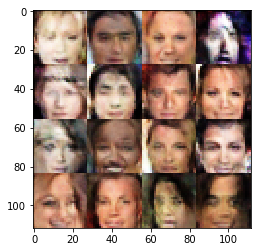

Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 3.2647
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 3.7010
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 2.7862
Epoch 1/1... Discriminator Loss: 0.5083... Generator Loss: 2.9678
Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 3.2205
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 3.4090
Epoch 1/1... Discriminator Loss: 0.5059... Generator Loss: 2.9192
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 2.9725
Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 3.4593
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 4.1863


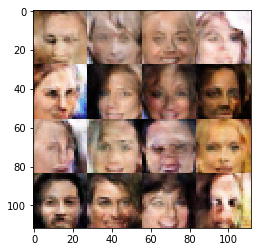

Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 3.3572
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 2.7049
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 3.0684
Epoch 1/1... Discriminator Loss: 0.4970... Generator Loss: 3.2012
Epoch 1/1... Discriminator Loss: 0.4870... Generator Loss: 3.5152
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 3.5590
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 3.8916
Epoch 1/1... Discriminator Loss: 0.5095... Generator Loss: 3.4876
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 2.7776
Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 2.5151


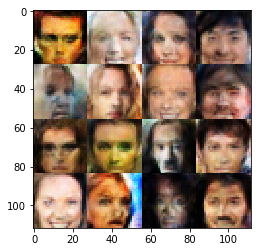

Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 3.2207
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 3.0939
Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 3.5160
Epoch 1/1... Discriminator Loss: 0.5115... Generator Loss: 2.9883
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 2.6720
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 3.6225
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 3.4403
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 3.1710
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 3.0878
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 3.1003


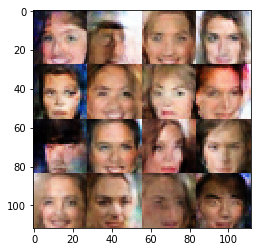

Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 3.3789
Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 3.0672
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 3.3169
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 4.8093
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 3.0712
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 3.0138
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 2.9615
Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 2.9356
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 2.8259
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 3.9342


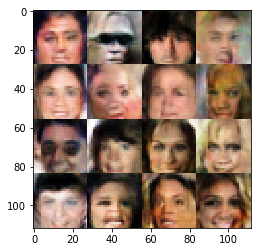

Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 3.3592
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 4.0214
Epoch 1/1... Discriminator Loss: 0.4945... Generator Loss: 3.8110
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 3.1634
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 3.5003
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 3.6895
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 3.6307
Epoch 1/1... Discriminator Loss: 0.4958... Generator Loss: 2.8757
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 3.0596
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 3.7178


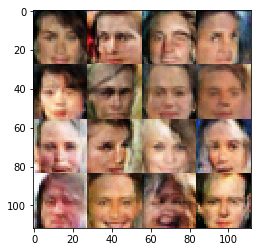

Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 2.9107
Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 2.9013
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 2.4598
Epoch 1/1... Discriminator Loss: 0.5197... Generator Loss: 2.8904
Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 3.8954
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 3.3719
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 3.2243
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 3.3085
Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 2.9858
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 3.1010


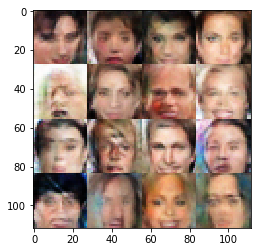

Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 3.1515
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 3.2678
Epoch 1/1... Discriminator Loss: 0.5103... Generator Loss: 3.1532
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 2.9780
Epoch 1/1... Discriminator Loss: 0.5603... Generator Loss: 2.4874
Epoch 1/1... Discriminator Loss: 0.5870... Generator Loss: 4.3825
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 3.4731
Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 3.3879
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 4.2000
Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 3.4528


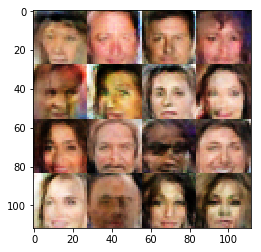

Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 3.5281
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 2.9543
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 3.3538
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 2.9864
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 2.8377
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 2.8536
Epoch 1/1... Discriminator Loss: 0.4855... Generator Loss: 3.3544
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 3.1093
Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 3.3609
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 2.8820


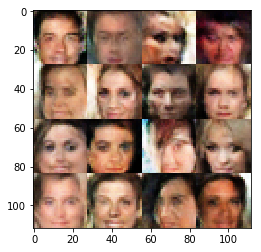

Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 3.2761
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 3.4576
Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 3.0870
Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 3.2841
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.9725
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 3.2778
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 3.7546
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 3.0945
Epoch 1/1... Discriminator Loss: 0.4945... Generator Loss: 3.3326
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 2.9028


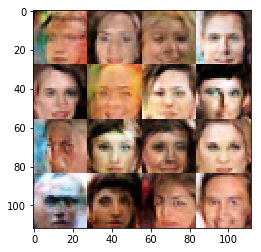

Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 3.2208
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 3.1890
Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 3.9937
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 2.3031
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 2.8412
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 2.7896
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 3.5776
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 3.3769
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 3.5765
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 4.2180


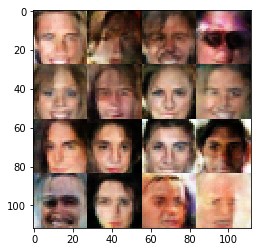

Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 2.8274
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 2.9574
Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 3.5331
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 2.8182
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 3.1586
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 3.2531
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 3.5308
Epoch 1/1... Discriminator Loss: 0.4846... Generator Loss: 3.5664
Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 3.3299
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 2.9449


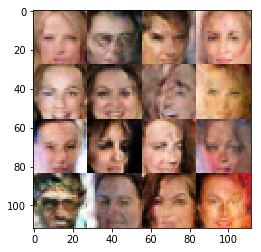

Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 3.3669
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.7837
Epoch 1/1... Discriminator Loss: 0.5159... Generator Loss: 3.0817
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 3.3894
Epoch 1/1... Discriminator Loss: 0.5287... Generator Loss: 3.0359
Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 3.1774
Epoch 1/1... Discriminator Loss: 0.4904... Generator Loss: 3.3344
Epoch 1/1... Discriminator Loss: 0.5503... Generator Loss: 2.7258
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 4.1534
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 3.4586


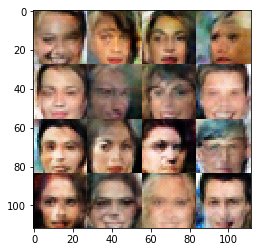

Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 3.6863
Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 3.1575
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 3.3321
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 3.0547
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 3.9405
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 3.4064
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 3.5255
Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 3.8610
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 3.2640
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 3.2233


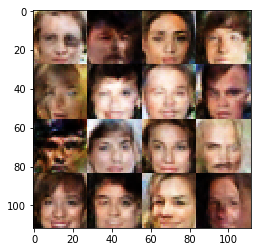

Epoch 1/1... Discriminator Loss: 0.5865... Generator Loss: 4.4408
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 3.2530
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 3.2353
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 3.2663
Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 3.4429
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 3.1120
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 3.9442
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.7721
Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 3.5368
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 2.9018


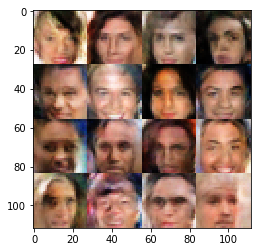

Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 3.5557
Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 3.7100
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 3.0196
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 3.4071
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 3.3448
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 3.1957
Epoch 1/1... Discriminator Loss: 0.5289... Generator Loss: 2.9614
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 3.5600
Epoch 1/1... Discriminator Loss: 0.5059... Generator Loss: 3.5970
Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 2.9696


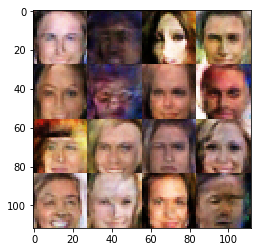

Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 3.0851
Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 3.3633
Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 3.2612
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.9366
Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 2.9431
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 3.2939
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 2.8996
Epoch 1/1... Discriminator Loss: 0.4914... Generator Loss: 3.1223
Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 2.7761
Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 2.9675


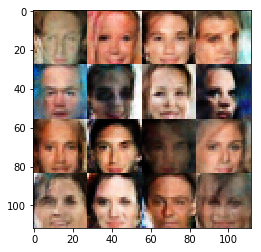

Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 3.9283
Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 2.8668
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 2.9558
Epoch 1/1... Discriminator Loss: 0.5041... Generator Loss: 2.8887
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 3.6253
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 3.2157
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 2.9056
Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 3.2011
Epoch 1/1... Discriminator Loss: 0.5051... Generator Loss: 3.2537
Epoch 1/1... Discriminator Loss: 0.5183... Generator Loss: 3.6199


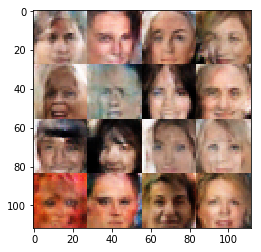

Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 3.4921
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 3.7108
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 2.9905
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 3.2070
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 3.4623
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 2.8250
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 2.9084
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 3.4896
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 3.0846
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 3.4789


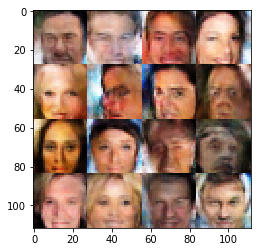

Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 3.5120
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 3.7245
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 2.8989
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 3.2131
Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 3.1283
Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 3.4349
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 3.6648
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 3.0508
Epoch 1/1... Discriminator Loss: 0.5159... Generator Loss: 3.8399
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 3.2423


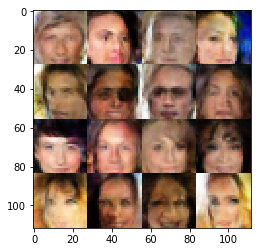

Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 3.5027
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 3.0673
Epoch 1/1... Discriminator Loss: 0.4975... Generator Loss: 3.4058
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 2.9263
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 3.3090
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 3.9436
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 3.5500
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 2.9397
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 3.3074
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 3.4351


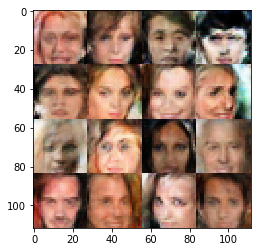

Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 3.8912
Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 3.6630
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 3.2933
Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 3.4182
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 3.1215
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 3.5629
Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 3.3456
Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 3.0023
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 3.2337
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 3.3784


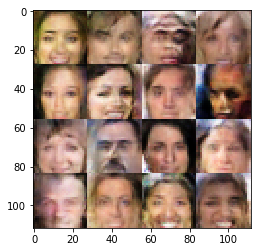

Epoch 1/1... Discriminator Loss: 0.5782... Generator Loss: 2.9971
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 3.2079
Epoch 1/1... Discriminator Loss: 0.4880... Generator Loss: 3.2452
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 3.2739
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 3.0906
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 3.6738
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 3.1493
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 2.9432
Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 3.1094
Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 3.6504


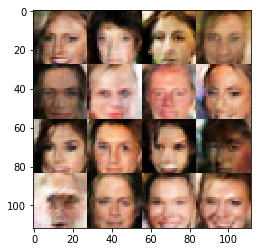

Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 2.6655
Epoch 1/1... Discriminator Loss: 0.4922... Generator Loss: 3.1516
Epoch 1/1... Discriminator Loss: 0.5666... Generator Loss: 3.9606
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 2.9529
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 4.5064
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 3.4004
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 3.3680
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 2.8513
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 3.5468
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 3.4461


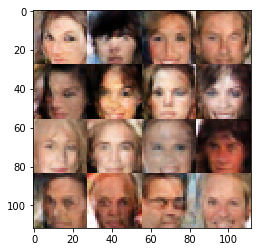

Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 2.9261
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 3.3149
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 3.0159
Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 3.7501
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 3.1658
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 3.1067
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 3.1370
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 2.8579
Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 3.4265
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 3.3817


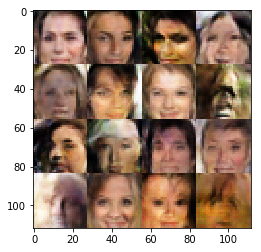

Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 2.9879
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 3.6381
Epoch 1/1... Discriminator Loss: 0.5384... Generator Loss: 2.7627
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 3.8400
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.9346
Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 3.8671
Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 2.8248
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 2.9955
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 3.3430
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 3.1410


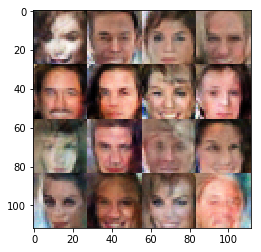

Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 3.1829
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 3.2726
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 3.7947
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 4.1312
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 3.2877
Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 3.7880
Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 3.2567
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 3.8790
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 2.7368
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 3.2726


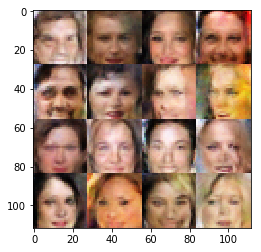

Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 3.0337
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 3.1077
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 3.2887
Epoch 1/1... Discriminator Loss: 0.4914... Generator Loss: 3.1916
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 3.4303
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 3.3658
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 3.0460
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 3.9737
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 3.4295
Epoch 1/1... Discriminator Loss: 0.4845... Generator Loss: 3.6970


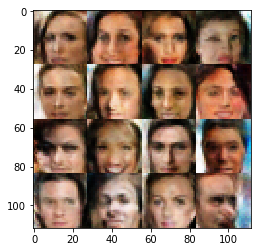

Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 2.6841
Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 4.2496
Epoch 1/1... Discriminator Loss: 0.4970... Generator Loss: 3.4396
Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 3.1808
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 3.0329
Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 3.2361
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 2.8041
Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 3.1482
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 3.7844
Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 3.7041


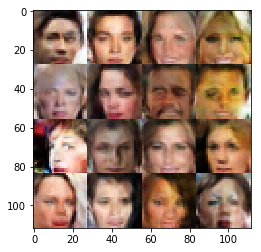

Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 3.4906
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 3.0278
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 3.4268
Epoch 1/1... Discriminator Loss: 0.5040... Generator Loss: 2.9740
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 3.0640
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 3.1243
Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 3.2270
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 3.4101
Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 2.9538
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 3.1786


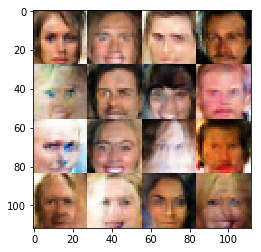

Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 2.5314
Epoch 1/1... Discriminator Loss: 0.4921... Generator Loss: 3.2914
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 4.0693
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 3.1315
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 3.3587
Epoch 1/1... Discriminator Loss: 0.4723... Generator Loss: 3.4374
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 3.5093
Epoch 1/1... Discriminator Loss: 0.4988... Generator Loss: 2.9555
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 3.0471
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 2.6582


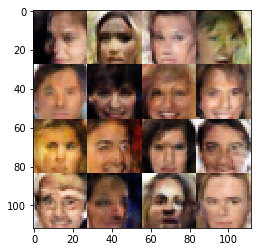

Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 2.7519
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 3.3266
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 3.4231
Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 3.1358
Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 3.0333
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 3.3145
Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 3.4422
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 2.6916
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 3.1494
Epoch 1/1... Discriminator Loss: 0.4988... Generator Loss: 3.1762


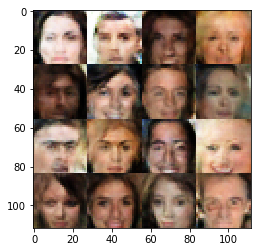

Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 2.9934
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 3.3402
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 3.4005
Epoch 1/1... Discriminator Loss: 0.4846... Generator Loss: 3.5250
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 3.1089
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 3.0949
Epoch 1/1... Discriminator Loss: 0.5041... Generator Loss: 3.8960
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 3.0273
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 3.2639
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 3.5020


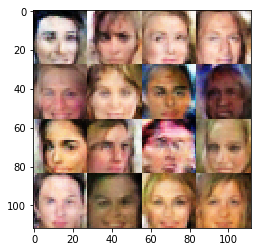

Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 3.2712
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 3.4670
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 3.5391
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 3.1761
Epoch 1/1... Discriminator Loss: 0.4945... Generator Loss: 3.1263
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 3.0785
Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 2.9454
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 3.0297
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 4.2221
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 3.9351


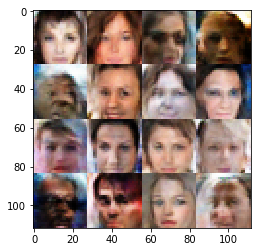

Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 3.2988
Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 3.4403
Epoch 1/1... Discriminator Loss: 0.5213... Generator Loss: 3.9966
Epoch 1/1... Discriminator Loss: 0.5316... Generator Loss: 2.5915
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 3.2094
Epoch 1/1... Discriminator Loss: 0.4871... Generator Loss: 3.8243
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 3.7445
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 3.0304
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 3.2452
Epoch 1/1... Discriminator Loss: 0.7159... Generator Loss: 5.2912


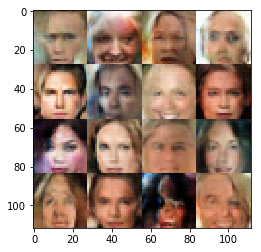

Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 3.1165
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 3.1398
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 3.8713
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 2.8026
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 3.7719
Epoch 1/1... Discriminator Loss: 0.4787... Generator Loss: 3.2862
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 3.5827
Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 3.3386
Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 3.4641
Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 4.0393


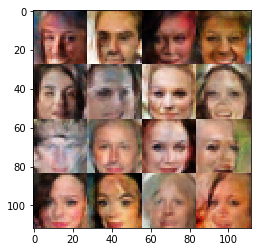

Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 3.7036
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 4.3679
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 3.0834
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 3.6955
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 3.2800
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 3.2413
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 3.3290
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 3.4246
Epoch 1/1... Discriminator Loss: 0.5213... Generator Loss: 3.0424
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 2.6765


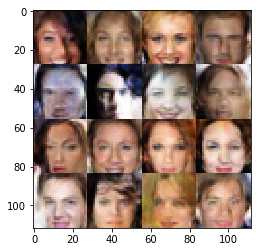

Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 3.6204
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 3.1666
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 2.8157
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 2.9285
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 2.9504
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 3.0691
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 4.2637
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 2.7351
Epoch 1/1... Discriminator Loss: 0.5390... Generator Loss: 3.9850
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 4.2019


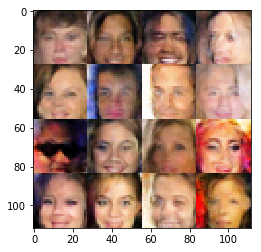

Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 3.0041
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 3.2371
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 3.2251
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 3.9175
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 4.0111
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 4.1103
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 2.5155
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 3.3513
Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 3.1629
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 3.8266


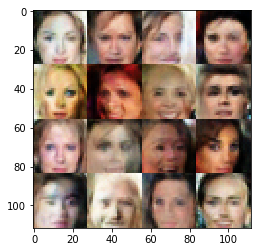

Epoch 1/1... Discriminator Loss: 0.5213... Generator Loss: 4.1131
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 3.8064
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 3.0316
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 3.6783
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 3.2211
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 3.6412
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 3.5039
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 4.2241
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 2.6558
Epoch 1/1... Discriminator Loss: 0.5301... Generator Loss: 2.7853


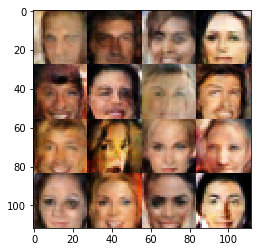

Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 3.4116
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 3.6558
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 3.4950
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 4.4622
Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 3.4638
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 3.1712
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 3.0617
Epoch 1/1... Discriminator Loss: 0.4855... Generator Loss: 3.5078
Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 3.2236
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 4.3493


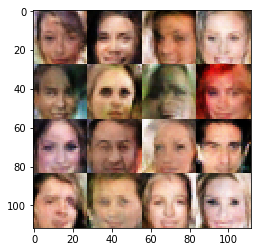

Epoch 1/1... Discriminator Loss: 0.4819... Generator Loss: 3.6911
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 3.8048
Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 3.3697
Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 3.5364
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 3.3396
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 3.4248
Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 3.7329
Epoch 1/1... Discriminator Loss: 0.4849... Generator Loss: 3.6397
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 3.0408
Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 3.1797


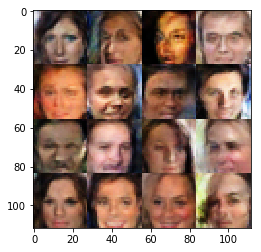

Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 3.6051
Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 3.3838
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 3.3023
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 3.4133
Epoch 1/1... Discriminator Loss: 0.4975... Generator Loss: 3.1415
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 3.2254
Epoch 1/1... Discriminator Loss: 0.5616... Generator Loss: 4.2703


In [36]:
batch_size = 16
z_dim = 100
learning_rate = 0.0006
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.